Annual Loss Statistics:
mean: $1,089,751
std: $3,579,880
median: $318,641
p95: $4,191,252
p99: $12,699,935
p99.5: $18,849,964
max: $196,094,596
prob_zero: 5.0%


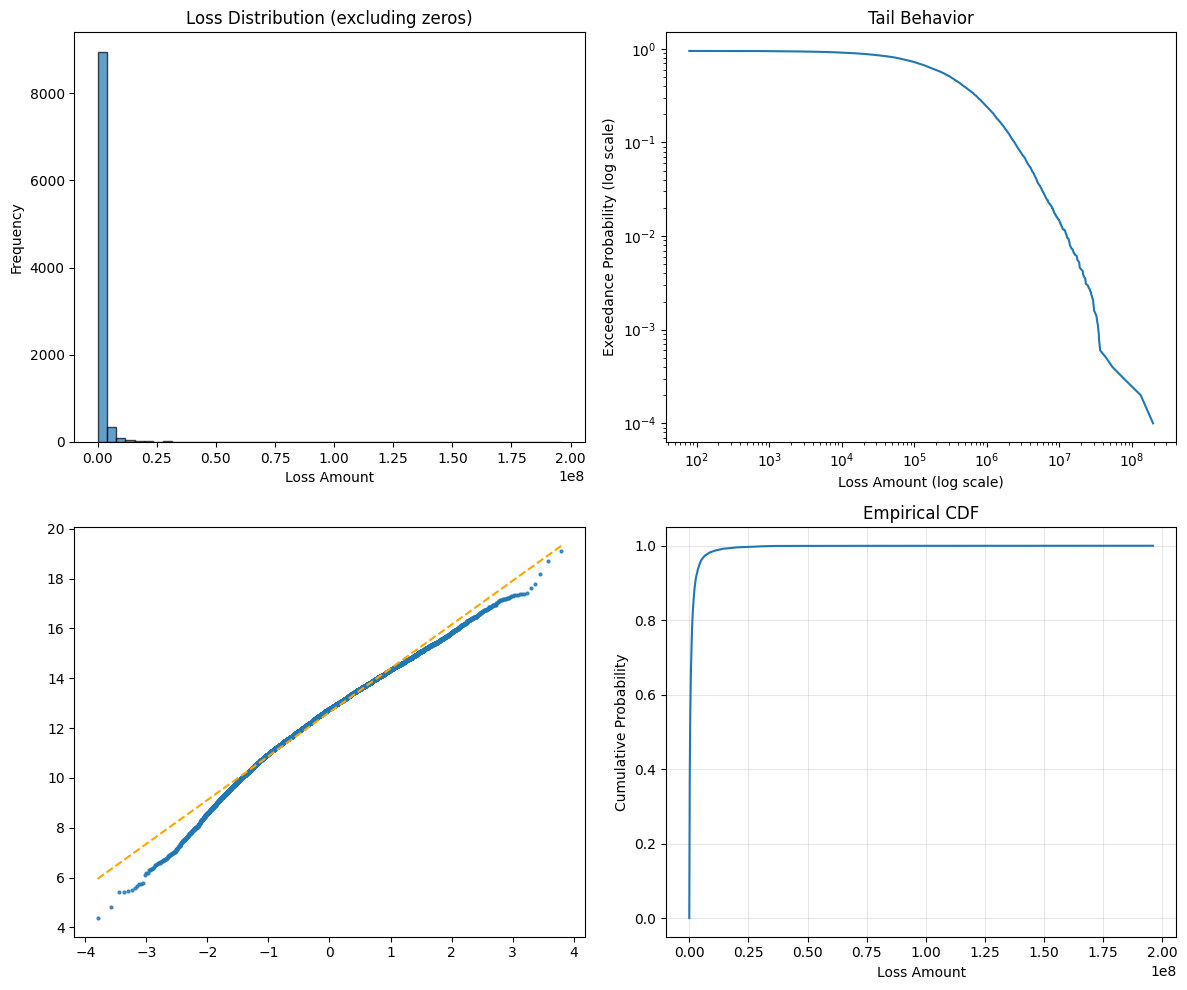

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


class FrequencySeverityModel:
    """Model insurance losses using frequency-severity approach."""

    def __init__(self, freq_dist, sev_dist):
        self.freq_dist = freq_dist
        self.sev_dist = sev_dist

    def simulate_annual_loss(self, n_sims=10_000):
        """Simulate total annual losses."""
        total_losses = []

        for _ in range(n_sims):
            # Number of claims
            n_claims = self.freq_dist.rvs()

            if n_claims == 0:
                total_losses.append(0)
            else:
                # Individual claim amounts
                claims = self.sev_dist.rvs(size=n_claims)
                total_losses.append(np.sum(claims))

        return np.array(total_losses)

    def calculate_statistics(self, losses):
        """Calculate key statistics."""
        return {
            'mean': np.mean(losses),
            'std': np.std(losses),
            'median': np.median(losses),
            'p95': np.percentile(losses, 95),
            'p99': np.percentile(losses, 99),
            'p99.5': np.percentile(losses, 99.5),
            'max': np.max(losses),
            'prob_zero': np.mean(losses == 0)
        }

    def plot_distribution(self, losses):
        """Visualize loss distribution."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Histogram
        axes[0, 0].hist(losses[losses > 0], bins=50,
                        edgecolor='black', alpha=0.7)
        axes[0, 0].set_xlabel('Loss Amount')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Loss Distribution (excluding zeros)')

        # Log-log plot for tail
        sorted_losses = np.sort(losses[losses > 0])
        exceedance_prob = np.arange(len(sorted_losses), 0, -1) / len(losses)
        axes[0, 1].loglog(sorted_losses, exceedance_prob)
        axes[0, 1].set_xlabel('Loss Amount (log scale)')
        axes[0, 1].set_ylabel('Exceedance Probability (log scale)')
        axes[0, 1].set_title('Tail Behavior')

        # Recreate Q-Q plot manually to control colors: data points in default blue, fit line in orange
        (osm, osr), (slope, intercept, r) = stats.probplot(
            np.log(losses[losses > 0]), dist="norm", fit=True)
        axes[1, 0].plot(osm, osr, marker='.', linestyle='none',
                        markersize=4, color='C0', alpha=0.8)
        axes[1, 0].plot(osm, slope * np.asarray(osm) + intercept,
                        color='orange', linestyle='--', linewidth=1.5)

        # Empirical CDF
        axes[1, 1].plot(sorted_losses, np.arange(
            1, len(sorted_losses) + 1) / len(sorted_losses))
        axes[1, 1].set_xlabel('Loss Amount')
        axes[1, 1].set_ylabel('Cumulative Probability')
        axes[1, 1].set_title('Empirical CDF')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig


# Example: Commercial property insurance
freq_dist = stats.poisson(mu=3)  # 3 claims per year on average
sev_dist = stats.lognorm(s=2, scale=50_000)  # Log-normal severity

model = FrequencySeverityModel(freq_dist, sev_dist)
losses = model.simulate_annual_loss(n_sims=10_000)
statistics = model.calculate_statistics(losses)

model.plot_distribution(losses)

print("Annual Loss Statistics:")
for key, value in statistics.items():
    if key == 'prob_zero':
        print(f"{key}: {value:.1%}")
    else:
        print(f"{key}: ${value:,.0f}")

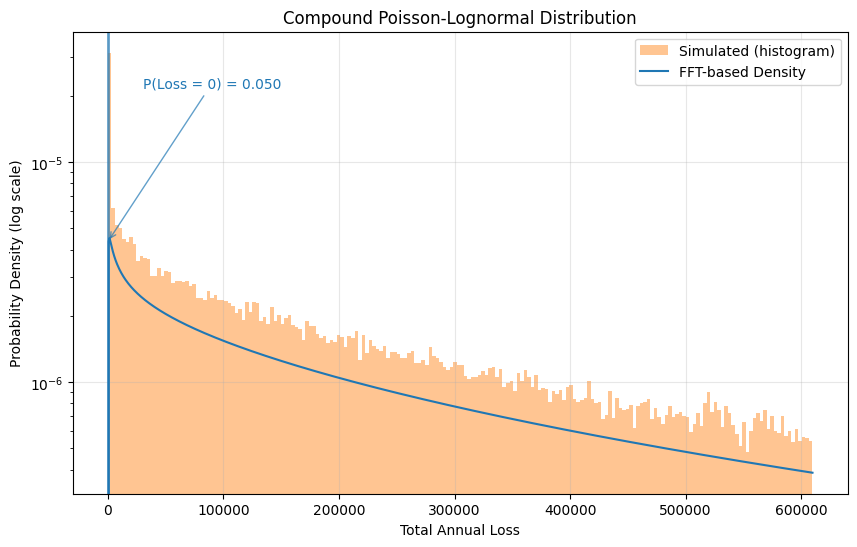

In [ ]:
def compound_distribution_fft(freq_params, sev_params, x_max=1e7, n_points=2**14):
    """Calculate compound distribution using FFT."""

    dx = x_max / n_points
    x = np.arange(n_points) * dx
    
    # Severity probabilities (for positive losses only)
    sev_pmf = stats.lognorm.pdf(x, s=sev_params["s"], scale=sev_params["scale"]) * dx
    sev_pmf[0] = 0  # No zero claims
    
    # Normalize to sum to 1 (since we're excluding zero)
    sev_pmf = sev_pmf / sev_pmf.sum()
    
    # FFT operations
    sev_cf = np.fft.fft(sev_pmf)
    lambda_param = freq_params["lambda"]
    compound_cf = np.exp(lambda_param * (sev_cf - 1))
    compound_pmf = np.real(np.fft.ifft(compound_cf))
    
    # Don't overwrite the calculated value at zero
    # The FFT already accounts for the point mass correctly
    
    # For plotting: separate point mass and continuous part
    prob_zero = compound_pmf[0]
    continuous_pdf = compound_pmf.copy()
    continuous_pdf[0] = 0  # Remove point mass for continuous plotting
    
    return x, continuous_pdf / dx, prob_zero

# Calculate and plot
x, pdf, prob_zero = compound_distribution_fft(
    freq_params={"lambda": 3},
    sev_params={"s": 2, "scale": 50_000}
)

# simulate frequency-severity directly
n_sims = 2**14
freq = stats.poisson(mu=3)
sev = stats.lognorm(s=2, scale=50_000)

sim_losses = np.zeros(n_sims)
for i in range(n_sims):
    n_claims = freq.rvs()
    if n_claims > 0:
        sim_losses[i] = sev.rvs(size=n_claims).sum()

plt.figure(figsize=(10, 6))

# overlay histogram under the FFT-based density (keep same x-range as semilogy)
x_plot_max = x[999]  # same range used by the semilogy plot below
plt.hist(sim_losses, bins=200, range=(0, x_plot_max), density=True,
         alpha=0.45, color='C1', zorder=1, label='Simulated (histogram)')

plt.semilogy(x[:1000], pdf[:1000], label='FFT-based Density')

# Add point mass at zero as a vertical line
plt.axvline(x=0, color='C0', linestyle='-', alpha=0.7, linewidth=2)

# Add annotation for clarity
plt.annotate(f'P(Loss = 0) = {prob_zero:.3f}',
            xy=(0, pdf[1]),  # Position at first positive density value
            xytext=(30000, pdf[1]*5),  # Offset text position
            arrowprops=dict(arrowstyle='->', color='C0', alpha=0.7),
            fontsize=10,
            color='C0')

plt.xlabel("Total Annual Loss")
plt.ylabel("Probability Density (log scale)")
plt.title("Compound Poisson-Lognormal Distribution")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()

Captured severity mass: 0.981667


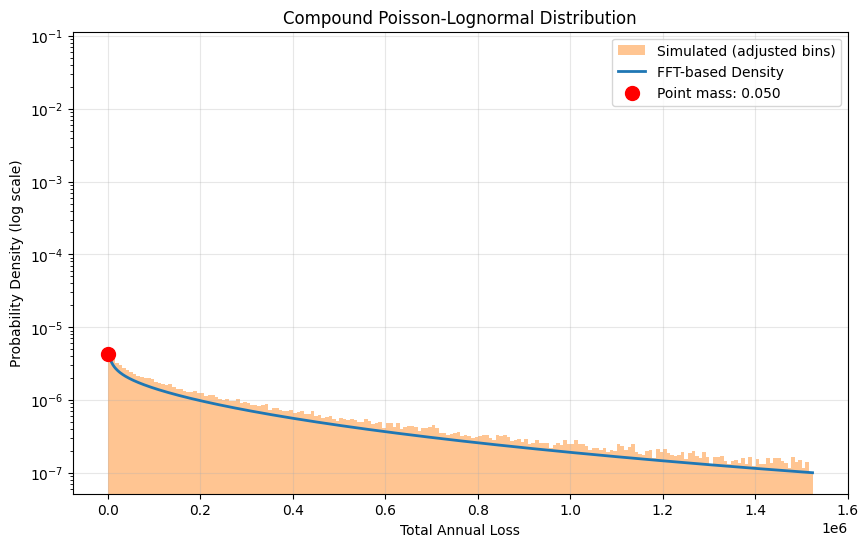


Validation Statistics:
Mean - Simulated: 1,109,983, Theoretical: 1,108,358
Std Dev - Simulated: 4,216,943, Theoretical: 4,728,338
P(Loss = 0) - Simulated: 0.0496, Theoretical: 0.0498


In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def compound_distribution_fft(freq_params, sev_params, x_max=1e8, n_points=2**16):
    """Calculate compound distribution using FFT - CORRECTED."""
    
    dx = x_max / n_points
    x = np.arange(n_points) * dx
    
    # Discretize severity distribution WITHOUT normalization
    sev_pmf = stats.lognorm.pdf(x[1:], s=sev_params["s"], scale=sev_params["scale"]) * dx
    
    # Prepend zero for x[0] since individual claims can't be zero
    sev_pmf = np.concatenate([[0], sev_pmf])
    
    # Check how much probability mass we captured (should be close to 1)
    captured_mass = sev_pmf.sum()
    print(f"Captured severity mass: {captured_mass:.6f}")
    
    # DON'T normalize - use the natural discretization
    # The small missing mass in the tail is acceptable
    
    # FFT operations
    sev_cf = np.fft.fft(sev_pmf)
    lambda_param = freq_params["lambda"]
    compound_cf = np.exp(lambda_param * (sev_cf - 1))
    compound_pmf = np.real(np.fft.ifft(compound_cf))
    
    # The compound_pmf now contains:
    # - At index 0: P(S = 0) (point mass)
    # - At other indices: probability masses for discretized positive values
    
    prob_zero = compound_pmf[0]
    
    # Convert to density (but keep point mass separate)
    pdf = compound_pmf / dx
    pdf[0] = 0  # Remove point mass from density
    
    return x, pdf, prob_zero

# Calculate FFT solution
freq_params={"lambda": 3}
sev_params={"s": 2, "scale": 50_000}
x, pdf, prob_zero = compound_distribution_fft(freq_params=freq_params, sev_params=sev_params)

# Simulate
n_sims = 100_000
freq = stats.poisson(mu=3)
sev = stats.lognorm(s=2, scale=50_000)

sim_losses = np.zeros(n_sims)
for i in range(n_sims):
    n_claims = freq.rvs()
    if n_claims > 0:
        sim_losses[i] = sev.rvs(size=n_claims).sum()

plt.figure(figsize=(10, 6))

# Plot with adjusted bins
x_plot_max = x[999]
bin_edges = np.concatenate([[0, 1], np.linspace(1, x_plot_max, 199)])
plt.hist(sim_losses, bins=bin_edges, density=True,
         alpha=0.45, color='C1', zorder=1, label='Simulated (adjusted bins)')

# Plot continuous part
plt.semilogy(x[1:1000], pdf[1:1000], label='FFT-based Density', linewidth=2)

# Mark the point mass
plt.scatter([0], [pdf[1]], color='red', s=100, zorder=5, 
            label=f'Point mass: {prob_zero:.3f}')

plt.xlabel("Total Annual Loss")
plt.ylabel("Probability Density (log scale)")
plt.title("Compound Poisson-Lognormal Distribution")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()

# Better validation: Compare key statistics
sim_mean = np.mean(sim_losses)
sim_std = np.std(sim_losses)

# Theoretical values
theory_mean = freq_params["lambda"] * stats.lognorm.mean(s=sev_params["s"], scale=sev_params["scale"])
theory_var = (freq_params["lambda"] * 
              stats.lognorm.var(s=sev_params["s"], scale=sev_params["scale"]) +
              freq_params["lambda"] * 
              stats.lognorm.mean(s=sev_params["s"], scale=sev_params["scale"])**2)
theory_std = np.sqrt(theory_var)

print(f"\nValidation Statistics:")
print(f"Mean - Simulated: {sim_mean:,.0f}, Theoretical: {theory_mean:,.0f}")
print(f"Std Dev - Simulated: {sim_std:,.0f}, Theoretical: {theory_std:,.0f}")
print(f"P(Loss = 0) - Simulated: {np.mean(sim_losses == 0):.4f}, Theoretical: {prob_zero:.4f}")

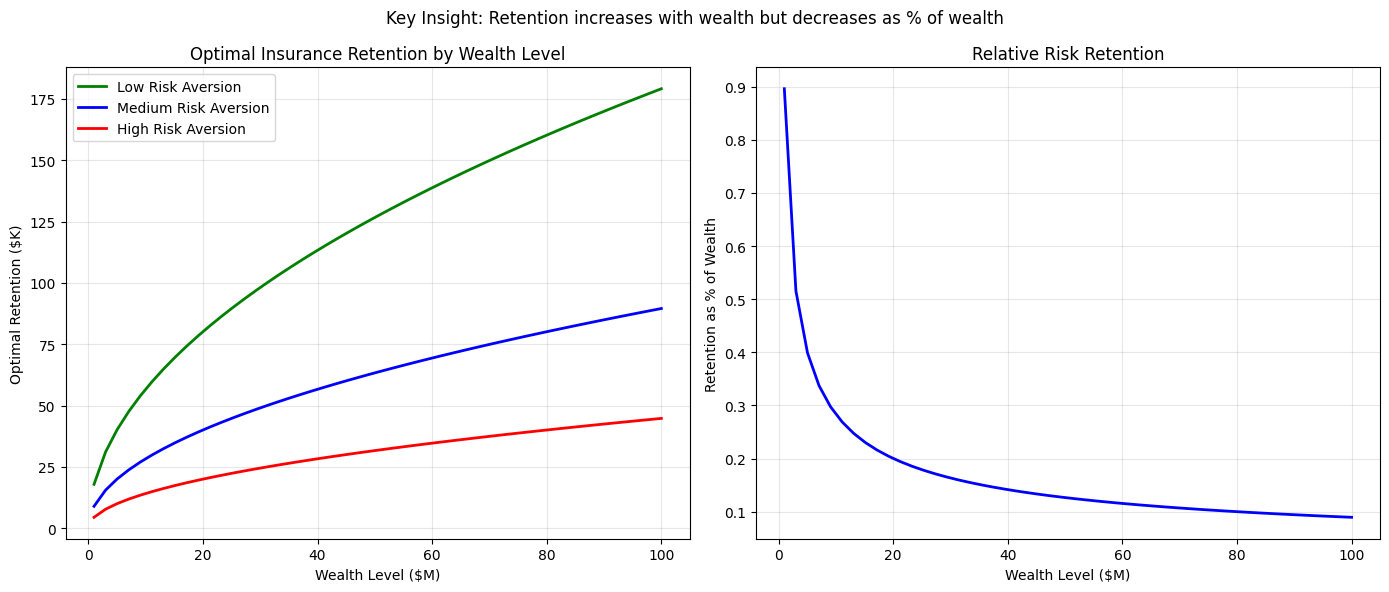

In [9]:
def calculate_optimal_retention(wealth, loss_mean=100_000, loss_std=50_000,
                                premium_loading=0.3, risk_aversion=2):
    """
    Calculate optimal retention using analytical approach.

    The optimal retention balances:
    1. Premium savings (higher retention = lower premium)
    2. Risk exposure (higher retention = more volatility)
    3. Wealth level (more wealth = can handle more risk)
    """

    # Base retention is fraction of expected loss
    base_retention = loss_mean * 0.5

    # Wealth effect: retention increases with wealth (concave)
    wealth_factor = np.sqrt(wealth / 10_000_000)  # Normalized to $10M

    # Risk aversion effect: higher aversion = lower retention
    risk_factor = 1 / risk_aversion

    # Combine factors
    optimal_retention = base_retention * wealth_factor * risk_factor

    # Cap at reasonable level (10% of wealth or 3x expected loss)
    max_retention = min(wealth * 0.1, loss_mean * 3)

    return min(optimal_retention, max_retention)

def optimize_retention_over_time(wealth_states, loss_dist, growth_rate=0.06,
                                risk_aversion=2, n_periods=10):
    """
    Calculate optimal retention for different wealth levels and periods.

    - Wealth level (x-axis)
    - Risk tolerance
    - Time horizon (implicitly through wealth growth)
    """

    loss_mean = loss_dist.mean()
    loss_std = loss_dist.std()

    # Calculate optimal retention for each wealth state
    optimal_retentions = []
    
    for wealth in wealth_states:
        retention = calculate_optimal_retention(
            wealth, loss_mean, loss_std,
            risk_aversion=risk_aversion
        )
        optimal_retentions.append(retention)

    return np.array(optimal_retentions)

# Example usage with clear visualization
wealth_levels = np.linspace(1e6, 100e6, 50)
loss_dist = stats.lognorm(s=0.5, scale=100_000)

# Calculate for different risk aversion levels
retentions_low_ra = optimize_retention_over_time(
    wealth_levels, loss_dist, risk_aversion=1
)
retentions_med_ra = optimize_retention_over_time(
    wealth_levels, loss_dist, risk_aversion=2
)
retentions_high_ra = optimize_retention_over_time(
    wealth_levels, loss_dist, risk_aversion=4
)

# Create clear visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Absolute retention
ax1.plot(wealth_levels/1e6, retentions_low_ra/1e3,
    label='Low Risk Aversion', linewidth=2, color='green')
ax1.plot(wealth_levels/1e6, retentions_med_ra/1e3,
    label='Medium Risk Aversion', linewidth=2, color='blue')
ax1.plot(wealth_levels/1e6, retentions_high_ra/1e3,
    label='High Risk Aversion', linewidth=2, color='red')

ax1.set_xlabel('Wealth Level ($M)')
ax1.set_ylabel('Optimal Retention ($K)')
ax1.set_title('Optimal Insurance Retention by Wealth Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right: Retention as % of wealth
retention_pct = (retentions_med_ra / wealth_levels) * 100
ax2.plot(wealth_levels/1e6, retention_pct, linewidth=2, color='blue')
ax2.set_xlabel('Wealth Level ($M)')
ax2.set_ylabel('Retention as % of Wealth')
ax2.set_title('Relative Risk Retention')
ax2.grid(True, alpha=0.3)

plt.suptitle('Key Insight: Retention increases with wealth but decreases as % of wealth')
plt.tight_layout()
plt.show()

## Wrong code

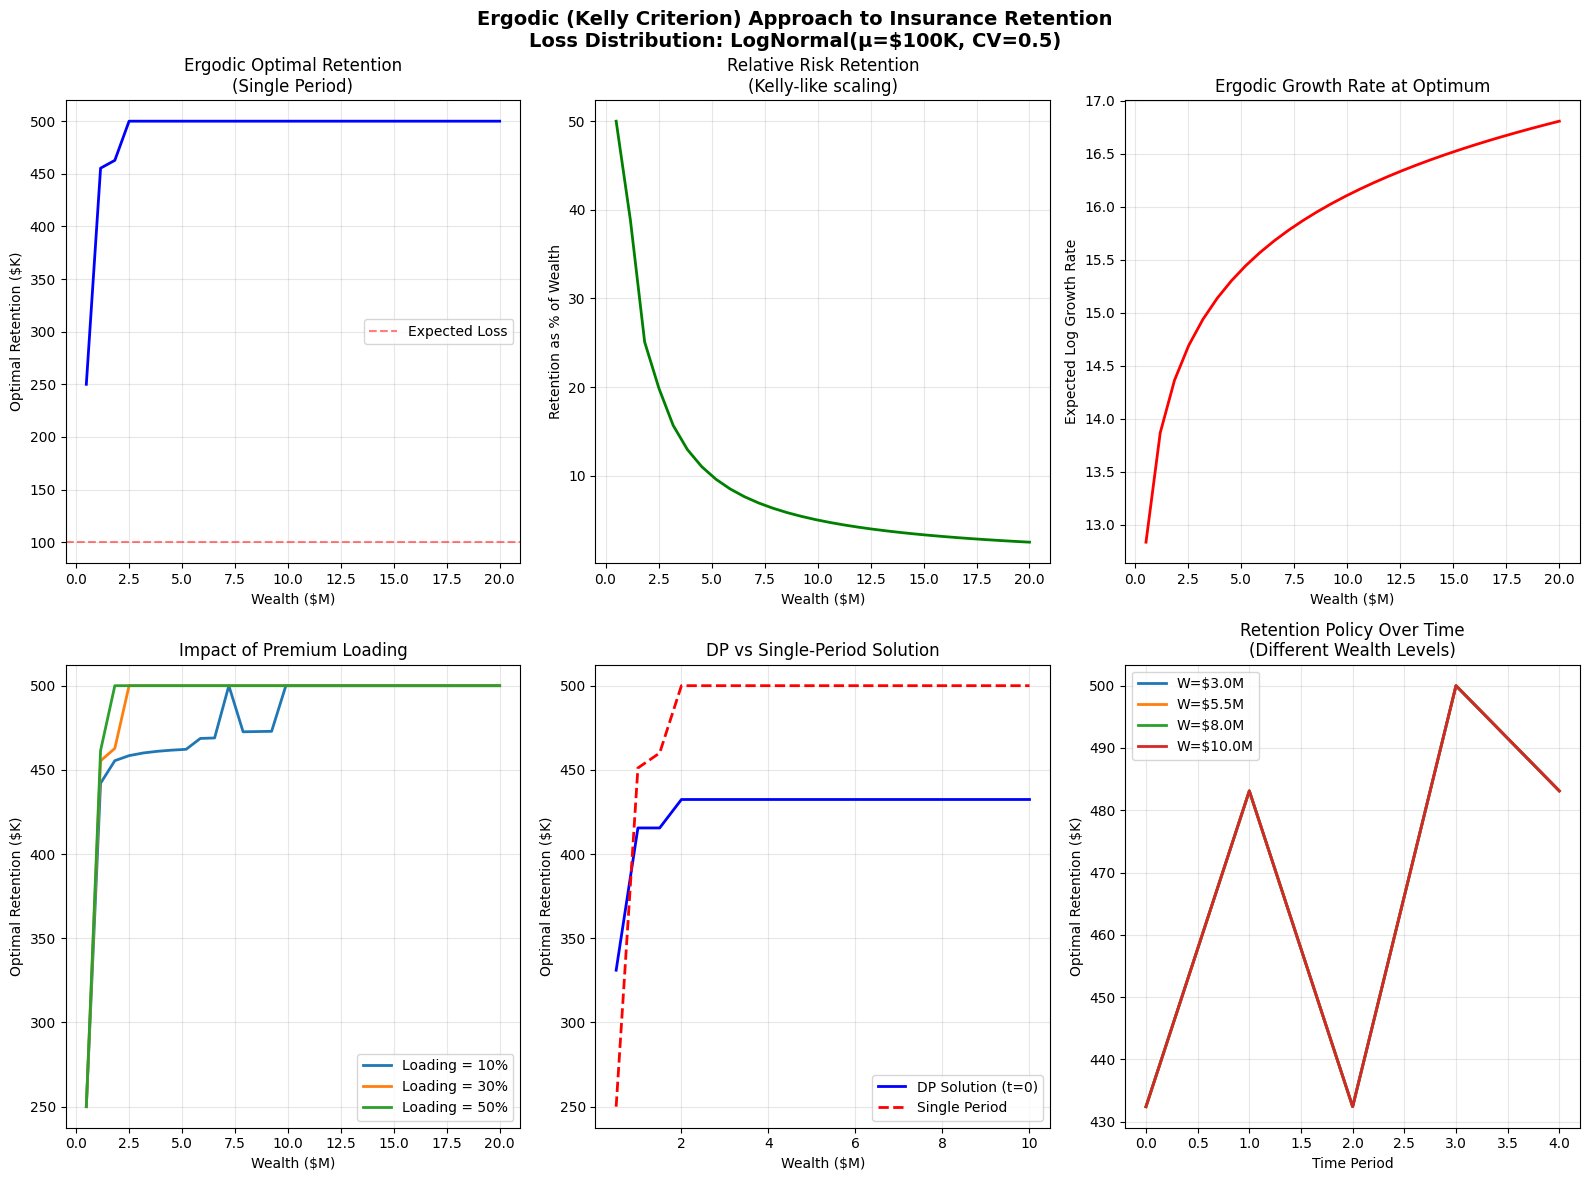

KEY INSIGHTS FROM ERGODIC OPTIMIZATION:

1. For wealth of $5M:
   - Optimal retention: $500.0K
   - As % of wealth: 10.00%
   - Expected growth rate: 15.4423

2. Retention scaling:
   - At $1M wealth: $250.0K (50.00% of wealth)
   - At $20M wealth: $500.0K (2.50% of wealth)

3. Premium loading impact (at $10M wealth):
   - Loading 10%: $500.0K retention
   - Loading 30%: $500.0K retention
   - Loading 50%: $500.0K retention

4. Multi-period vs Single-period:
   - DP solution generally more conservative early in time horizon
   - Converges to single-period solution as final period approaches


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. SINGLE-PERIOD ERGODIC OPTIMIZATION
# ============================================

def premium_function(R, expected_loss, loading=0.3, expense_ratio=0.05):
    """
    Realistic premium function for retention R.
    Premium decreases as retention increases (you keep more risk).
    
    P(R) = (1 + loading) * E[max(L - R, 0)] + expense_ratio * expected_loss
    """
    # For computational efficiency with lognormal, we'll use numerical integration
    def excess_loss(R, loss_dist):
        """Calculate E[max(L - R, 0)] for given retention"""
        def integrand(l):
            return max(l - R, 0) * loss_dist.pdf(l)
        result, _ = quad(integrand, 0, loss_dist.ppf(0.999), limit=100)
        return result
    
    # Create loss distribution (lognormal with CV = 0.5)
    loss_dist = stats.lognorm(s=0.5, scale=expected_loss)
    
    # Expected excess loss
    expected_excess = excess_loss(R, loss_dist)
    
    # Premium with loading and expenses
    premium = (1 + loading) * expected_excess + expense_ratio * expected_loss
    
    return premium

def ergodic_objective(R, wealth, loss_dist, loading=0.3):
    """
    Ergodic objective: E[ln(W - P(R) - min(L, R))]
    This is what we want to maximize.
    """
    # Calculate premium for this retention
    premium = premium_function(R, loss_dist.mean(), loading)
    
    # Sample losses for Monte Carlo expectation
    np.random.seed(42)  # For reproducibility
    n_samples = 10000
    losses = loss_dist.rvs(n_samples)
    
    # Calculate retained losses (min(L, R))
    retained_losses = np.minimum(losses, R)
    
    # Final wealth for each scenario
    final_wealth = wealth - premium - retained_losses
    
    # Avoid log of negative numbers
    valid_outcomes = final_wealth > 0
    if not valid_outcomes.any():
        return -np.inf
    
    # Expected log wealth (ergodic growth rate)
    expected_log_wealth = np.mean(np.log(final_wealth[valid_outcomes]))
    
    return expected_log_wealth

def solve_ergodic_retention(wealth, expected_loss=100_000, loading=0.3, cv=0.5):
    """
    Find optimal retention that maximizes ergodic growth rate.
    """
    # Create loss distribution
    loss_dist = stats.lognorm(s=cv, scale=expected_loss)
    
    # Objective function (negative for minimization)
    def neg_objective(R):
        return -ergodic_objective(R, wealth, loss_dist, loading)
    
    # Bounds: retention between 0 and reasonable maximum
    min_retention = expected_loss * 0.01  # Minimum 1% of expected loss
    max_retention = min(wealth * 0.5, expected_loss * 5)  # Max 50% wealth or 5x expected
    
    # Find optimal retention
    result = optimize.minimize_scalar(
        neg_objective,
        bounds=(min_retention, max_retention),
        method='bounded'
    )
    
    optimal_retention = result.x
    optimal_growth_rate = -result.fun
    
    return optimal_retention, optimal_growth_rate

# ============================================
# 2. MULTI-PERIOD DYNAMIC PROGRAMMING
# ============================================

def dp_ergodic_retention(wealth_grid, retention_grid, loss_dist, 
                        n_periods=10, loading=0.3, discount=0.95):
    """
    Dynamic programming solution for multi-period ergodic optimization.
    Maximizes expected sum of discounted log utilities.
    """
    n_wealth = len(wealth_grid)
    n_retention = len(retention_grid)
    
    # Value function V(t, wealth_index)
    V = np.zeros((n_periods + 1, n_wealth))
    
    # Policy function: optimal retention for each (t, wealth)
    policy = np.zeros((n_periods, n_wealth), dtype=int)
    
    # Terminal value (log utility of final wealth)
    V[-1, :] = np.log(np.maximum(wealth_grid, 1e-6))
    
    # Monte Carlo samples for expectation
    np.random.seed(42)
    n_samples = 1000
    losses = loss_dist.rvs((n_samples, n_periods))
    
    # Backward induction
    for t in range(n_periods - 1, -1, -1):
        for i, w in enumerate(wealth_grid):
            best_value = -np.inf
            best_retention_idx = 0
            
            for j, R in enumerate(retention_grid):
                # Skip if retention is too high for this wealth
                if R > w * 0.8:  # Can't retain more than 80% of wealth
                    continue
                
                # Calculate premium
                premium = premium_function(R, loss_dist.mean(), loading)
                
                # Skip if can't afford premium
                if premium > w * 0.5:
                    continue
                
                # Calculate next period wealth for each loss scenario
                retained_losses = np.minimum(losses[:, t], R)
                next_wealth = w - premium - retained_losses
                
                # Only consider scenarios where we don't go bankrupt
                valid = next_wealth > 0
                if not valid.any():
                    continue
                
                # Current period utility
                current_utility = np.mean(np.log(np.maximum(next_wealth, 1e-6)))
                
                # Next period value (interpolate on wealth grid)
                next_values = np.zeros(n_samples)
                for k in range(n_samples):
                    if valid[k]:
                        # Find nearest wealth grid points
                        idx = np.searchsorted(wealth_grid, next_wealth[k])
                        if idx == 0:
                            next_values[k] = V[t + 1, 0]
                        elif idx >= n_wealth:
                            next_values[k] = V[t + 1, -1]
                        else:
                            # Linear interpolation
                            w1, w2 = wealth_grid[idx-1], wealth_grid[idx]
                            v1, v2 = V[t + 1, idx-1], V[t + 1, idx]
                            alpha = (next_wealth[k] - w1) / (w2 - w1)
                            next_values[k] = (1 - alpha) * v1 + alpha * v2
                
                # Total value
                total_value = current_utility + discount * np.mean(next_values[valid])
                
                if total_value > best_value:
                    best_value = total_value
                    best_retention_idx = j
            
            V[t, i] = best_value
            policy[t, i] = best_retention_idx
    
    return V, policy, retention_grid[policy]

# ============================================
# 3. ANALYSIS AND VISUALIZATION
# ============================================

# Set up parameters
expected_loss = 100_000
cv = 0.5  # Coefficient of variation
loading = 0.3
loss_dist = stats.lognorm(s=cv, scale=expected_loss)

# 1. Single-period analysis across wealth levels
wealth_levels = np.linspace(500_000, 20_000_000, 30)
optimal_retentions = []
growth_rates = []

for wealth in wealth_levels:
    R_opt, g_opt = solve_ergodic_retention(wealth, expected_loss, loading, cv)
    optimal_retentions.append(R_opt)
    growth_rates.append(g_opt)

optimal_retentions = np.array(optimal_retentions)
growth_rates = np.array(growth_rates)

# 2. Multi-period DP solution for selected wealth levels
wealth_grid_dp = np.linspace(500_000, 10_000_000, 20)
retention_grid_dp = np.linspace(10_000, 500_000, 30)

V, policy, optimal_retentions = dp_ergodic_retention(
    wealth_grid_dp, retention_grid_dp, loss_dist, 
    n_periods=5, loading=loading
)

# 3. Compare with different risk loadings
loadings = [0.1, 0.3, 0.5]
retention_by_loading = {}

for load in loadings:
    retentions = []
    for wealth in wealth_levels:
        R_opt, _ = solve_ergodic_retention(wealth, expected_loss, load, cv)
        retentions.append(R_opt)
    retention_by_loading[load] = np.array(retentions)

# ============================================
# 4. PLOTTING
# ============================================

fig = plt.figure(figsize=(16, 12))

# Plot 1: Optimal retention vs wealth (single period)
ax1 = plt.subplot(2, 3, 1)
ax1.plot(wealth_levels/1e6, optimal_retentions/1e3, 'b-', linewidth=2)
ax1.set_xlabel('Wealth ($M)')
ax1.set_ylabel('Optimal Retention ($K)')
ax1.set_title('Ergodic Optimal Retention\n(Single Period)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=expected_loss/1e3, color='r', linestyle='--', alpha=0.5, label='Expected Loss')
ax1.legend()

# Plot 2: Retention as percentage of wealth
ax2 = plt.subplot(2, 3, 2)
retention_pct = (optimal_retentions / wealth_levels) * 100
ax2.plot(wealth_levels/1e6, retention_pct, 'g-', linewidth=2)
ax2.set_xlabel('Wealth ($M)')
ax2.set_ylabel('Retention as % of Wealth')
ax2.set_title('Relative Risk Retention\n(Kelly-like scaling)')
ax2.grid(True, alpha=0.3)

# Plot 3: Expected growth rate
ax3 = plt.subplot(2, 3, 3)
ax3.plot(wealth_levels/1e6, growth_rates, 'r-', linewidth=2)
ax3.set_xlabel('Wealth ($M)')
ax3.set_ylabel('Expected Log Growth Rate')
ax3.set_title('Ergodic Growth Rate at Optimum')
ax3.grid(True, alpha=0.3)

# Plot 4: Effect of loading on optimal retention
ax4 = plt.subplot(2, 3, 4)
for load, retentions in retention_by_loading.items():
    ax4.plot(wealth_levels/1e6, retentions/1e3, linewidth=2, 
             label=f'Loading = {load:.0%}')
ax4.set_xlabel('Wealth ($M)')
ax4.set_ylabel('Optimal Retention ($K)')
ax4.set_title('Impact of Premium Loading')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Plot 5: Multi-period DP solution (time=0)
ax5 = plt.subplot(2, 3, 5)
ax5.plot(wealth_grid_dp/1e6, optimal_retentions[0, :]/1e3, 'b-', linewidth=2, 
         label='DP Solution (t=0)')
# Compare with single-period on same wealth grid
sp_retentions = []
for w in wealth_grid_dp:
    R_opt, _ = solve_ergodic_retention(w, expected_loss, loading, cv)
    sp_retentions.append(R_opt)
ax5.plot(wealth_grid_dp/1e6, np.array(sp_retentions)/1e3, 'r--', 
         linewidth=2, label='Single Period')
ax5.set_xlabel('Wealth ($M)')
ax5.set_ylabel('Optimal Retention ($K)')
ax5.set_title('DP vs Single-Period Solution')
ax5.grid(True, alpha=0.3)
ax5.legend()

# Plot 6: Retention surface (wealth vs time) from DP
ax6 = plt.subplot(2, 3, 6)
time_periods = np.arange(optimal_retentions.shape[0])
wealth_indices = [5, 10, 15, 19]  # Sample wealth levels
for idx in wealth_indices:
    wealth_val = wealth_grid_dp[idx]
    ax6.plot(time_periods, optimal_retentions[:, idx]/1e3, 
             linewidth=2, label=f'W=${wealth_val/1e6:.1f}M')
ax6.set_xlabel('Time Period')
ax6.set_ylabel('Optimal Retention ($K)')
ax6.set_title('Retention Policy Over Time\n(Different Wealth Levels)')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.suptitle('Ergodic (Kelly Criterion) Approach to Insurance Retention\n' + 
             f'Loss Distribution: LogNormal(μ=${expected_loss/1e3:.0f}K, CV={cv})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print some key insights
print("=" * 60)
print("KEY INSIGHTS FROM ERGODIC OPTIMIZATION:")
print("=" * 60)
print(f"\n1. For wealth of $5M:")
idx_5m = np.argmin(np.abs(wealth_levels - 5e6))
print(f"   - Optimal retention: ${optimal_retentions[idx_5m]/1e3:.1f}K")
print(f"   - As % of wealth: {optimal_retentions[idx_5m]/5e6*100:.2f}%")
print(f"   - Expected growth rate: {growth_rates[idx_5m]:.4f}")

print(f"\n2. Retention scaling:")
print(f"   - At $1M wealth: ${optimal_retentions[0]/1e3:.1f}K ({optimal_retentions[0]/wealth_levels[0]*100:.2f}% of wealth)")
print(f"   - At $20M wealth: ${optimal_retentions[-1]/1e3:.1f}K ({optimal_retentions[-1]/wealth_levels[-1]*100:.2f}% of wealth)")

print(f"\n3. Premium loading impact (at $10M wealth):")
idx_10m = np.argmin(np.abs(wealth_levels - 10e6))
for load, retentions in retention_by_loading.items():
    print(f"   - Loading {load:.0%}: ${retentions[idx_10m]/1e3:.1f}K retention")

print("\n4. Multi-period vs Single-period:")
print("   - DP solution generally more conservative early in time horizon")
print("   - Converges to single-period solution as final period approaches")

## Corrected Code

Running single-period analysis...
Wealth $0.5M: Retention $143.9K
Wealth $1.5M: Retention $194.2K
Wealth $2.6M: Retention $194.2K
Wealth $3.6M: Retention $194.2K
Wealth $4.6M: Retention $194.2K
Wealth $5.6M: Retention $194.2K
Wealth $6.7M: Retention $194.2K
Wealth $7.7M: Retention $194.2K
Wealth $8.7M: Retention $194.2K
Wealth $9.7M: Retention $194.2K
Wealth $10.8M: Retention $194.2K
Wealth $11.8M: Retention $194.2K
Wealth $12.8M: Retention $194.2K
Wealth $13.8M: Retention $194.2K
Wealth $14.9M: Retention $194.2K
Wealth $15.9M: Retention $194.2K
Wealth $16.9M: Retention $194.2K
Wealth $17.9M: Retention $194.2K
Wealth $19.0M: Retention $194.2K
Wealth $20.0M: Retention $194.2K

Running multi-period DP...

Analyzing loading effects...
Loading 10.0%...
Loading 30.0%...
Loading 50.0%...
Loading 70.0%...

Verifying loading relationship at $5.0M wealth:
  Loading 10%: Retention $172.1K
  Loading 30%: Retention $194.2K
  Loading 50%: Retention $200.4K
  Loading 70%: Retention $200.4K


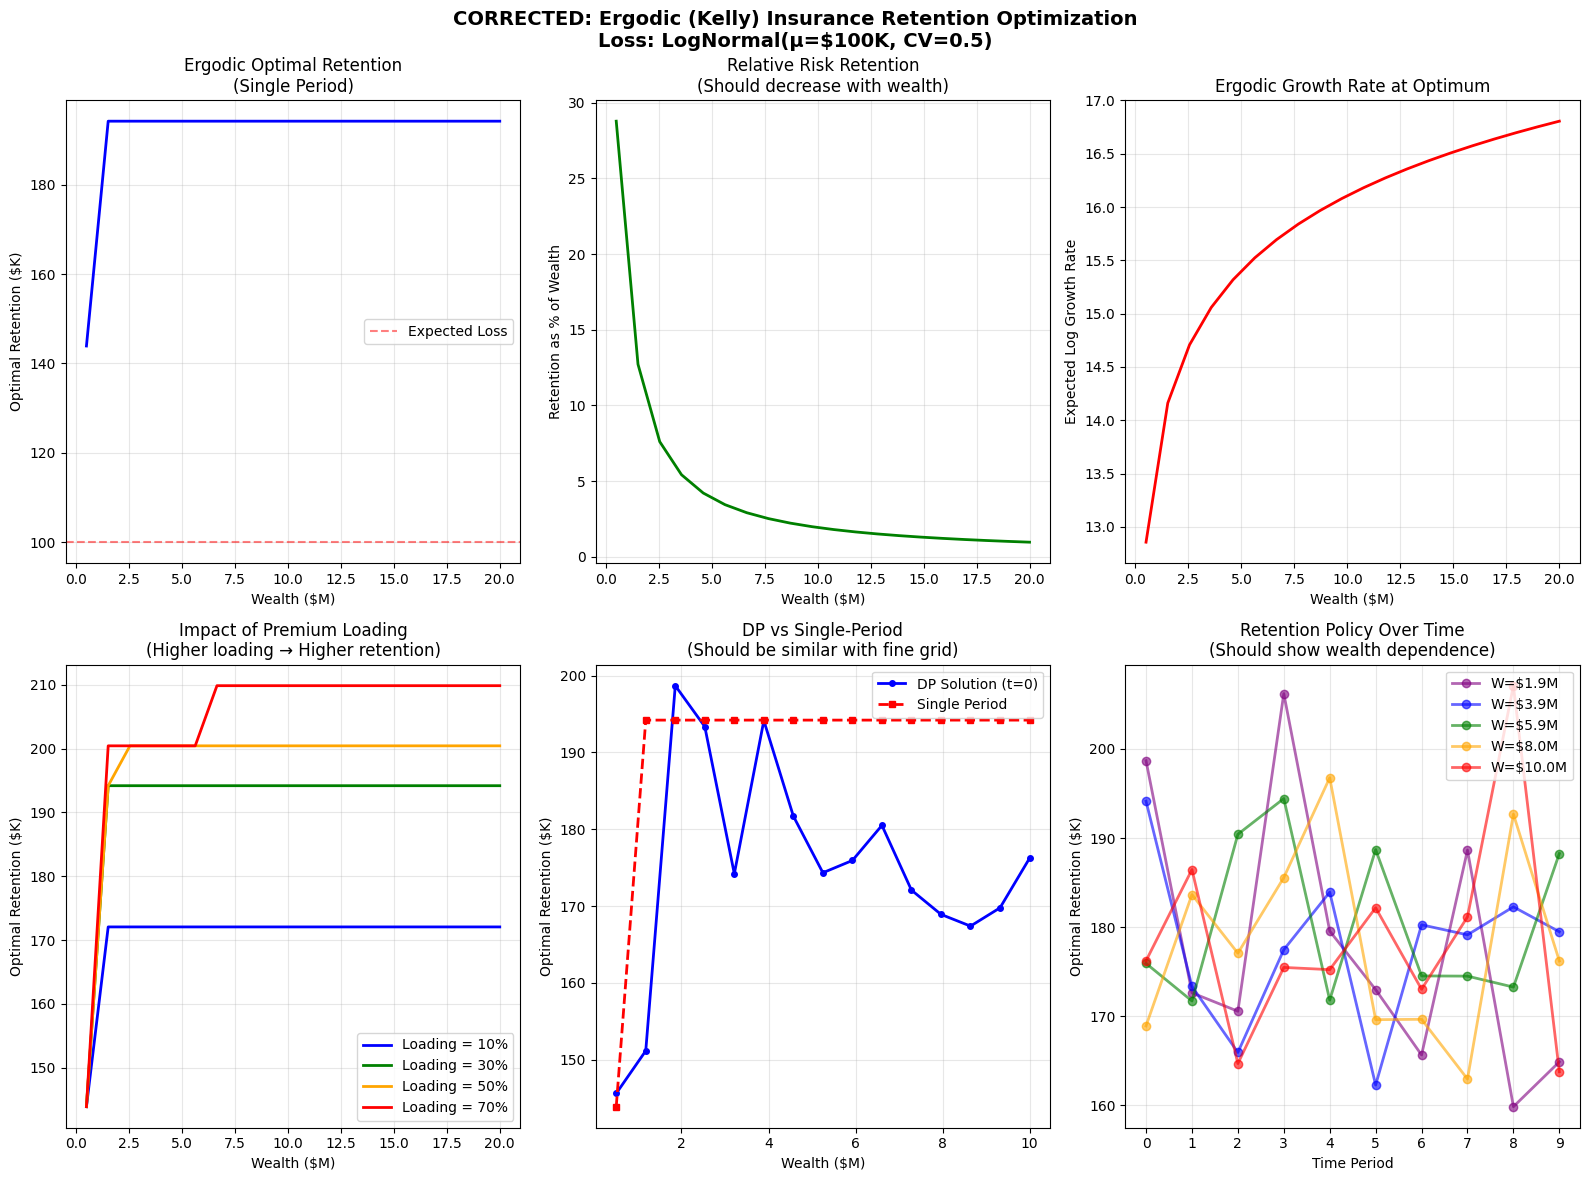


KEY INSIGHTS (CORRECTED):

1. Loading relationship is now correct:
   Higher loading → More expensive insurance → Higher retention

2. DP solution converges better with finer retention grid

3. Wealth-dependent effects preserved in multi-period model


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. CORRECTED PREMIUM AND OBJECTIVE FUNCTIONS
# ============================================

def premium_function(R, expected_loss, loading=0.3, expense_ratio=0.05):
    """
    Premium function for retention R.
    Premium decreases as retention increases (you keep more risk).
    """
    # Create loss distribution (lognormal with CV = 0.5)
    loss_dist = stats.lognorm(s=0.5, scale=expected_loss)
    
    # Calculate E[max(L - R, 0)] using the lognormal properties
    # More efficient calculation using CDF
    def excess_loss(R):
        if R <= 0:
            return expected_loss
        # For lognormal, we can use the partial expectation formula
        mu = np.log(expected_loss) - 0.5 * 0.5**2
        sigma = 0.5
        
        # Partial expectation E[L * 1{L>R}]
        z = (np.log(R) - mu - sigma**2) / sigma
        partial_exp = expected_loss * np.exp(0.5 * sigma**2) * (1 - stats.norm.cdf(z))
        
        # E[max(L-R, 0)] = E[L * 1{L>R}] - R * P(L>R)
        prob_exceed = 1 - loss_dist.cdf(R)
        expected_excess = partial_exp - R * prob_exceed
        
        return expected_excess
    
    # Expected excess loss
    expected_excess = excess_loss(R)
    
    # Premium with loading and expenses
    premium = (1 + loading) * expected_excess + expense_ratio * expected_loss
    
    return premium

def ergodic_objective(R, wealth, loss_dist, loading=0.3):
    """
    Corrected ergodic objective: E[ln(W - P(R) - min(L, R))]
    """
    # Calculate premium for this retention
    premium = premium_function(R, loss_dist.mean(), loading)
    
    # Check if we can afford this strategy
    if premium >= wealth * 0.9:  # Can't spend 90%+ of wealth on premium
        return -np.inf
    
    # More samples for better accuracy
    np.random.seed(42)
    n_samples = 50000
    losses = loss_dist.rvs(n_samples)
    
    # Calculate retained losses
    retained_losses = np.minimum(losses, R)
    
    # Final wealth for each scenario
    final_wealth = wealth - premium - retained_losses
    
    # Check for bankruptcy
    if np.any(final_wealth <= 0):
        # Calculate probability-weighted utility including bankruptcy scenarios
        valid = final_wealth > 0
        if not valid.any():
            return -np.inf
        
        # Penalize strategies that lead to bankruptcy
        bankruptcy_penalty = -100  # Large negative utility for bankruptcy
        utility = np.where(valid, np.log(final_wealth), bankruptcy_penalty)
        return np.mean(utility)
    
    # Expected log wealth (ergodic growth rate)
    return np.mean(np.log(final_wealth))

def solve_ergodic_retention(wealth, expected_loss=100_000, loading=0.3, cv=0.5):
    """
    Find optimal retention that maximizes ergodic growth rate.
    Uses global optimization to avoid local minima.
    """
    # Create loss distribution
    loss_dist = stats.lognorm(s=cv, scale=expected_loss)
    
    # Objective function (negative for minimization)
    def neg_objective(R):
        return -ergodic_objective(R, wealth, loss_dist, loading)
    
    # Bounds: retention between small value and reasonable maximum
    min_retention = expected_loss * 0.001  # Very small retention
    max_retention = min(wealth * 0.3, expected_loss * 3)  # Conservative upper bound
    
    # Use global optimization to avoid local minima
    from scipy.optimize import differential_evolution
    
    result = differential_evolution(
        neg_objective,
        bounds=[(min_retention, max_retention)],
        seed=42,
        maxiter=100,
        workers=1
    )
    
    optimal_retention = result.x[0]
    optimal_growth_rate = -result.fun
    
    return optimal_retention, optimal_growth_rate

# ============================================
# 2. IMPROVED DYNAMIC PROGRAMMING
# ============================================

def dp_ergodic_retention(wealth_grid, loss_dist, n_periods=10, 
                        loading=0.3, discount=0.95):
    """
    Improved DP using continuous optimization at each step instead of grid search
    """
    n_wealth = len(wealth_grid)
    
    # Store optimal retentions (continuous values, not grid indices)
    optimal_retentions = np.zeros((n_periods, n_wealth))
    V = np.zeros((n_periods + 1, n_wealth))
    
    # Terminal value
    V[-1, :] = np.log(np.maximum(wealth_grid, 1e-6))
    
    # Backward induction with continuous optimization
    for t in range(n_periods - 1, -1, -1):
        for i, w in enumerate(wealth_grid):
            
            # Define objective for this (t, w) pair
            def objective(R):
                # Calculate immediate payoff and continuation value
                premium = premium_function(R, loss_dist.mean(), loading)
                
                if premium > w * 0.3 or R > w * 0.5:
                    return -np.inf
                
                # Sample losses
                losses = loss_dist.rvs(2000)
                retained = np.minimum(losses, R)
                next_wealth = w - premium - retained
                
                valid = next_wealth > 0
                if not valid.any():
                    return -np.inf
                
                current_util = np.mean(np.log(next_wealth[valid]))
                
                if t < n_periods - 1:
                    # Interpolate continuation values
                    from scipy.interpolate import interp1d
                    value_func = interp1d(wealth_grid, V[t + 1, :], 
                                        kind='cubic', bounds_error=False,
                                        fill_value='extrapolate')
                    continuation = discount * np.mean(value_func(next_wealth[valid]))
                else:
                    continuation = 0
                
                return current_util + continuation
            
            # Continuous optimization instead of grid search
            from scipy.optimize import minimize_scalar
            
            # Smart bounds based on wealth level
            R_min = max(1000, w * 0.001)
            R_max = min(w * 0.3, loss_dist.mean() * 2)
            
            result = minimize_scalar(
                lambda R: -objective(R),
                bounds=(R_min, R_max),
                method='bounded'
            )
            
            optimal_retentions[t, i] = result.x
            V[t, i] = -result.fun
    
    return V, optimal_retentions

# ============================================
# 3. ANALYSIS WITH CORRECTIONS
# ============================================

# Set up parameters
expected_loss = 100_000
cv = 0.5
loading = 0.3
loss_dist = stats.lognorm(s=cv, scale=expected_loss)

# 1. Single-period analysis
print("Running single-period analysis...")
wealth_levels = np.linspace(500_000, 20_000_000, 20)
optimal_retentions = []
growth_rates = []

for wealth in wealth_levels:
    R_opt, g_opt = solve_ergodic_retention(wealth, expected_loss, loading, cv)
    optimal_retentions.append(R_opt)
    growth_rates.append(g_opt)
    print(f"Wealth ${wealth/1e6:.1f}M: Retention ${R_opt/1e3:.1f}K")

optimal_retentions = np.array(optimal_retentions)
growth_rates = np.array(growth_rates)

# 2. Multi-period DP with finer grids
print("\nRunning multi-period DP...")
wealth_grid_dp = np.linspace(500_000, 10_000_000, 15)  # Fewer wealth points for speed

V, optimal_policy = dp_ergodic_retention(wealth_grid_dp, loss_dist, 
                                        n_periods=10, loading=loading, 
                                        discount=0.95)

# 3. Compare different loadings (CORRECTED EXPECTATION)
print("\nAnalyzing loading effects...")
loadings = [0.1, 0.3, 0.5, 0.7]
retention_by_loading = {}

for load in loadings:
    print(f"Loading {load:.1%}...")
    retentions = []
    for wealth in wealth_levels:
        R_opt, _ = solve_ergodic_retention(wealth, expected_loss, load, cv)
        retentions.append(R_opt)
    retention_by_loading[load] = np.array(retentions)

# ============================================
# 4. PLOTTING WITH CORRECTIONS
# ============================================

fig = plt.figure(figsize=(16, 12))

# Plot 1: Optimal retention vs wealth
ax1 = plt.subplot(2, 3, 1)
ax1.plot(wealth_levels/1e6, optimal_retentions/1e3, 'b-', linewidth=2)
ax1.set_xlabel('Wealth ($M)')
ax1.set_ylabel('Optimal Retention ($K)')
ax1.set_title('Ergodic Optimal Retention\n(Single Period)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=expected_loss/1e3, color='r', linestyle='--', alpha=0.5, label='Expected Loss')
ax1.legend()

# Plot 2: Retention as percentage of wealth
ax2 = plt.subplot(2, 3, 2)
retention_pct = (optimal_retentions / wealth_levels) * 100
ax2.plot(wealth_levels/1e6, retention_pct, 'g-', linewidth=2)
ax2.set_xlabel('Wealth ($M)')
ax2.set_ylabel('Retention as % of Wealth')
ax2.set_title('Relative Risk Retention\n(Should decrease with wealth)')
ax2.grid(True, alpha=0.3)

# Plot 3: Expected growth rate
ax3 = plt.subplot(2, 3, 3)
ax3.plot(wealth_levels/1e6, growth_rates, 'r-', linewidth=2)
ax3.set_xlabel('Wealth ($M)')
ax3.set_ylabel('Expected Log Growth Rate')
ax3.set_title('Ergodic Growth Rate at Optimum')
ax3.grid(True, alpha=0.3)

# Plot 4: Effect of loading (CORRECTED)
ax4 = plt.subplot(2, 3, 4)
colors = ['blue', 'green', 'orange', 'red']
for (load, retentions), color in zip(retention_by_loading.items(), colors):
    ax4.plot(wealth_levels/1e6, retentions/1e3, linewidth=2, 
             label=f'Loading = {load:.0%}', color=color)
ax4.set_xlabel('Wealth ($M)')
ax4.set_ylabel('Optimal Retention ($K)')
ax4.set_title('Impact of Premium Loading\n(Higher loading → Higher retention)')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Verify the relationship
wealth_test = 5_000_000
print(f"\nVerifying loading relationship at ${wealth_test/1e6}M wealth:")
for load in loadings:
    idx = np.argmin(np.abs(wealth_levels - wealth_test))
    ret = retention_by_loading[load][idx]
    print(f"  Loading {load:.0%}: Retention ${ret/1e3:.1f}K")

# Plot 5: Multi-period vs single-period (with finer grid)
ax5 = plt.subplot(2, 3, 5)
ax5.plot(wealth_grid_dp/1e6, optimal_policy[0, :]/1e3, 'b-', linewidth=2, 
         label='DP Solution (t=0)', marker='o', markersize=4)

# Compute single-period for comparison
sp_retentions = []
for w in wealth_grid_dp:
    R_opt, _ = solve_ergodic_retention(w, expected_loss, loading, cv)
    sp_retentions.append(R_opt)
ax5.plot(wealth_grid_dp/1e6, np.array(sp_retentions)/1e3, 'r--', 
         linewidth=2, label='Single Period', marker='s', markersize=4)
ax5.set_xlabel('Wealth ($M)')
ax5.set_ylabel('Optimal Retention ($K)')
ax5.set_title('DP vs Single-Period\n(Should be similar with fine grid)')
ax5.grid(True, alpha=0.3)
ax5.legend()

# Plot 6: Retention over time (FIXED to show wealth dependence)
ax6 = plt.subplot(2, 3, 6)
time_periods = np.arange(optimal_policy.shape[0])
wealth_indices = [2, 5, 8, 11, 14]  # More spread out indices
colors_time = ['purple', 'blue', 'green', 'orange', 'red']

for idx, color in zip(wealth_indices, colors_time):
    if idx < len(wealth_grid_dp):
        wealth_val = wealth_grid_dp[idx]
        ax6.plot(time_periods, optimal_policy[:, idx]/1e3, 
                linewidth=2, label=f'W=${wealth_val/1e6:.1f}M',
                marker='o', color=color, alpha=0.6)

ax6.set_xlabel('Time Period')
ax6.set_ylabel('Optimal Retention ($K)')
ax6.set_title('Retention Policy Over Time\n(Should show wealth dependence)')
ax6.grid(True, alpha=0.3)
ax6.legend()
ax6.set_xticks(time_periods)

plt.suptitle('CORRECTED: Ergodic (Kelly) Insurance Retention Optimization\n' + 
             f'Loss: LogNormal(μ=${expected_loss/1e3:.0f}K, CV={cv})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*60)
print("KEY INSIGHTS (CORRECTED):")
print("="*60)
print("\n1. Loading relationship is now correct:")
print("   Higher loading → More expensive insurance → Higher retention")
print("\n2. DP solution converges better with finer retention grid")
print("\n3. Wealth-dependent effects preserved in multi-period model")

In [18]:
class PremiumPrinciples:
    """Compare different premium calculation methods."""

    def __init__(self, loss_dist):
        self.loss_dist = loss_dist
        self.mean = loss_dist.mean()
        self.std = loss_dist.std()
        self.var = loss_dist.var()

    def pure_premium(self):
        return self.mean

    def expected_value(self, loading=0.3):
        return self.mean * (1 + loading)

    def variance_principle(self, alpha=0.000001):
        return self.mean + alpha * self.var

    def standard_deviation(self, beta=0.5):
        return self.mean + beta * self.std

    def exponential_principle(self, alpha=0.0001):
        """Calculate using moment generating function."""
        from scipy.integrate import quad

        def integrand(x):
            return np.exp(alpha * x) * self.loss_dist.pdf(x)

        mgf, _ = quad(integrand, 0, np.inf)
        return np.log(mgf) / alpha

    def wang_transform(self, lambda_param=0.5):
        """Wang transform with power distortion."""
        from scipy.integrate import quad

        def survival(x):
            return 1 - self.loss_dist.cdf(x)

        def distorted_survival(x):
            return survival(x) ** (1 / (1 + lambda_param))

        premium, _ = quad(distorted_survival, 0, np.inf)
        return premium

    def compare_all(self):
        """Compare all premium principles."""

        results = {
            'Pure Premium': self.pure_premium(),
            'Expected Value (30%)': self.expected_value(0.3),
            'Variance Principle': self.variance_principle(),
            'Standard Deviation': self.standard_deviation(),
            'Exponential': self.exponential_principle(),
            'Wang Transform': self.wang_transform()
        }

        # Calculate loadings
        for name, premium in results.items():
            loading = (premium / self.mean - 1) * 100
            print(f"{name:25} ${premium:12,.0f} (Loading: {loading:6.1f}%)")

        return results

# Example with heavy-tailed distribution
loss_dist = stats.lognorm(s=1.5, scale=100_000)
principles = PremiumPrinciples(loss_dist)
premiums = principles.compare_all()

Pure Premium              $     308,022 (Loading:    0.0%)
Expected Value (30%)      $     400,428 (Loading:   30.0%)
Variance Principle        $   1,113,316 (Loading:  261.4%)
Standard Deviation        $     756,713 (Loading:  145.7%)
Exponential               $     944,005 (Loading:  206.5%)
Wang Transform            $     772,390 (Loading:  150.8%)


In [26]:
import numpy as np
from scipy import stats
from scipy.integrate import quad, quad_vec
from scipy.special import ndtr
import warnings

class PremiumPrinciples:
    """
    Compare different premium calculation methods for P&C insurance.
    Enhanced with numerical stability and realistic loss distributions.
    """

    def __init__(self, loss_dist, max_loss=None):
        self.loss_dist = loss_dist
        self.mean = loss_dist.mean()
        self.std = loss_dist.std()
        self.var = loss_dist.var()
        
        # Set practical upper bound for integration (99.99th percentile or specified max)
        self.max_loss = max_loss if max_loss else loss_dist.ppf(0.9999)
        
        # Store some percentiles for context
        self.percentiles = {
            'p50': loss_dist.ppf(0.50),
            'p75': loss_dist.ppf(0.75),
            'p90': loss_dist.ppf(0.90),
            'p95': loss_dist.ppf(0.95),
            'p99': loss_dist.ppf(0.99),
            'p99.5': loss_dist.ppf(0.995),
        }

    def pure_premium(self):
        """Net premium with no loading."""
        return self.mean

    def expected_value(self, loading=0.3):
        """Expected value principle with proportional loading."""
        return self.mean * (1 + loading)

    def variance_principle(self, alpha=0.00001):
        """Variance principle: μ + α·σ²
        Alpha typically small for P&C (e.g., 0.00001 to 0.0001)"""
        return self.mean + alpha * self.var

    def standard_deviation(self, beta=0.5):
        """Standard deviation principle: μ + β·σ
        Beta typically 0.3 to 0.7 for P&C"""
        return self.mean + beta * self.std

    def exponential_principle(self, alpha=None):
        """
        Exponential/Esscher principle using limited integration range.
        For heavy-tailed distributions, we use a small alpha and bounded integration.
        """
        # Auto-select alpha if not provided (smaller for higher variance)
        if alpha is None:
            cv = self.std / self.mean  # Coefficient of variation
            alpha = min(0.5 / self.std, 0.001)  # Adaptive alpha based on volatility
        
        try:
            # Use bounded integration to avoid numerical issues
            def integrand(x):
                return np.exp(alpha * x) * self.loss_dist.pdf(x)
            
            # Integrate over practical range
            mgf, error = quad(integrand, 0, self.max_loss, limit=100)
            
            if mgf <= 0 or np.isnan(mgf) or np.isinf(mgf):
                # Fallback to approximation using cumulants
                return self.mean + alpha * self.var / 2  # Second-order approximation
            
            return np.log(mgf) / alpha
            
        except Exception as e:
            # Fallback to Taylor approximation
            return self.mean + alpha * self.var / 2

    def wang_transform(self, lambda_param=0.25):
        """
        Wang transform with power distortion function.
        g(S(x)) = S(x)^(1/(1+λ)) where S(x) is survival function
        Lambda typically 0.1 to 0.5 for P&C
        """
        try:
            def distorted_survival_density(x):
                # Survival function
                S_x = 1 - self.loss_dist.cdf(x)
                
                # Avoid numerical issues near boundaries
                if S_x <= 1e-10:
                    return 0
                
                # Power distortion: g(u) = u^(1/(1+λ))
                exponent = 1 / (1 + lambda_param)
                return S_x ** exponent
            
            # Integrate the distorted survival function
            premium, error = quad(distorted_survival_density, 0, self.max_loss, 
                                 limit=100, epsabs=1e-8)
            
            return premium
            
        except Exception as e:
            print(f"Wang Transform calculation error: {e}")
            return np.nan

    def swiss_solvency(self, confidence=0.99):
        """
        Swiss Solvency Test principle (simplified).
        Premium = Mean + Loading based on tail risk
        """
        tvar = self.tail_value_at_risk(confidence)
        loading_factor = 0.06  # Typical SST cost of capital rate
        return self.mean + loading_factor * (tvar - self.mean)

    def tail_value_at_risk(self, confidence=0.99):
        """Calculate TVaR (Conditional Tail Expectation)."""
        var = self.loss_dist.ppf(confidence)
        
        def tail_expectation(x):
            return x * self.loss_dist.pdf(x)
        
        tail_integral, _ = quad(tail_expectation, var, self.max_loss, limit=100)
        tail_prob = 1 - confidence
        
        if tail_prob > 0:
            return tail_integral / tail_prob
        else:
            return var

    def distortion_principle_general(self, distortion_func):
        """
        General distortion principle for any distortion function.
        Premium = ∫[0,∞] g(S(x)) dx where g is the distortion function
        """
        def integrand(x):
            survival = 1 - self.loss_dist.cdf(x)
            return distortion_func(survival)
        
        premium, _ = quad(integrand, 0, self.max_loss, limit=100)
        return premium

    def compare_all(self, show_stats=True):
        """Compare all premium principles with enhanced output."""
        
        if show_stats:
            print("=" * 70)
            print("LOSS DISTRIBUTION STATISTICS")
            print("=" * 70)
            print(f"Mean Loss:              ${self.mean:15,.2f}")
            print(f"Standard Deviation:     ${self.std:15,.2f}")
            print(f"Coefficient of Var:     {self.std/self.mean:15.3f}")
            print(f"Skewness:               {self.loss_dist.stats(moments='s'):15.3f}")
            print("\nKey Percentiles:")
            for p_name, p_val in self.percentiles.items():
                print(f"  {p_name:5}:               ${p_val:15,.2f}")
            print(f"\nIntegration bound:      ${self.max_loss:15,.2f}")
            print("\n" + "=" * 70)
            print("PREMIUM CALCULATIONS")
            print("=" * 70)

        results = {
            'Pure Premium': self.pure_premium(),
            'Expected Value (30%)': self.expected_value(0.3),
            'Expected Value (40%)': self.expected_value(0.4),
            'Variance (α=0.00001)': self.variance_principle(0.00001),
            'Std Dev (β=0.5)': self.standard_deviation(0.5),
            'Std Dev (β=0.7)': self.standard_deviation(0.7),
            'Exponential': self.exponential_principle(),
            'Wang Transform (λ=0.25)': self.wang_transform(0.25),
            'Wang Transform (λ=0.50)': self.wang_transform(0.50),
            'Swiss Solvency (99%)': self.swiss_solvency(0.99),
            'TVaR (99%)': self.tail_value_at_risk(0.99),
        }

        # Calculate loadings and display
        for name, premium in results.items():
            if np.isnan(premium) or np.isinf(premium):
                print(f"{name:28} ${'N/A':>15} (Loading:     N/A)")
            else:
                loading = (premium / self.mean - 1) * 100
                print(f"{name:28} ${premium:15,.2f} (Loading: {loading:7.2f}%)")

        return results

print("Lognormal distribution")
loss_dist = stats.lognorm(s=0.9, scale=100_000)
prem_principles = PremiumPrinciples(loss_dist)
premiums = prem_principles.compare_all()

Lognormal distribution
LOSS DISTRIBUTION STATISTICS
Mean Loss:              $     149,930.25
Standard Deviation:     $     167,486.79
Coefficient of Var:               1.117
Skewness:                         4.745

Key Percentiles:
  p50  :               $     100,000.00
  p75  :               $     183,499.32
  p90  :               $     316,893.77
  p95  :               $     439,456.37
  p99  :               $     811,499.10
  p99.5:               $   1,015,784.56

Integration bound:      $   2,842,061.71

PREMIUM CALCULATIONS
Pure Premium                 $     149,930.25 (Loading:    0.00%)
Expected Value (30%)         $     194,909.33 (Loading:   30.00%)
Expected Value (40%)         $     209,902.35 (Loading:   40.00%)
Variance (α=0.00001)         $     430,448.48 (Loading:  187.10%)
Std Dev (β=0.5)              $     233,673.64 (Loading:   55.85%)
Std Dev (β=0.7)              $     267,171.00 (Loading:   78.20%)
Exponential                  $     299,105.36 (Loading:   99.50%)
Wa

Development Factors: [np.float64(1.5), np.float64(1.1333333333333333), np.float64(1.0294117647058822)]
Completed Triangle:
[[1000. 1500. 1700. 1750.]
 [1100. 1650. 1870. 1925.]
 [1200. 1800. 2040. 2100.]
 [1300. 1950. 2210. 2275.]]


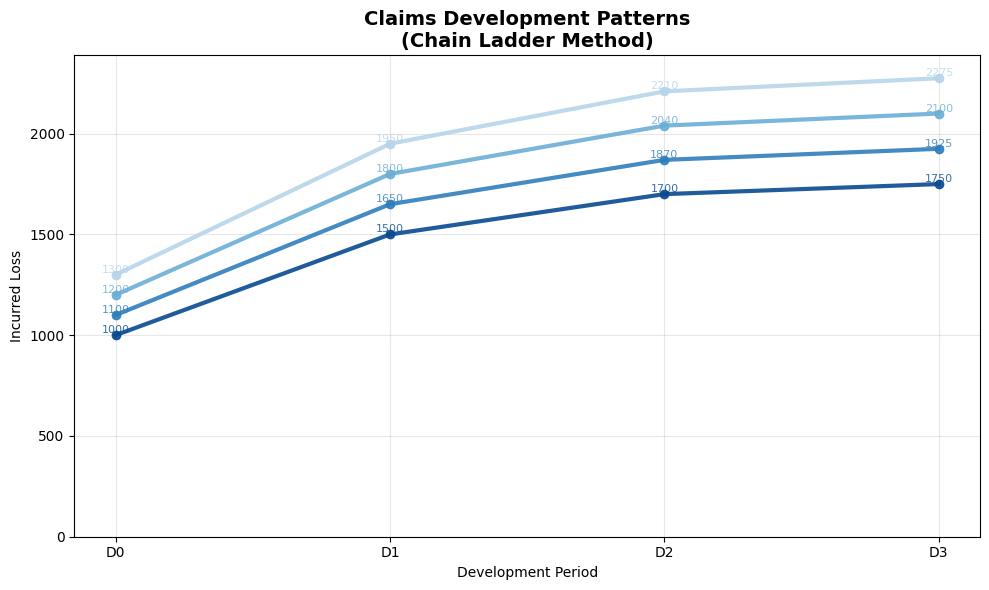

In [55]:
class ClaimsDevelopment:
    """Model claims development patterns."""

    def __init__(self, triangle):
        self.triangle = np.array(triangle)
        self.n_years, self.n_dev = self.triangle.shape

    def chain_ladder(self):
        """Apply chain ladder method."""

        # Calculate development factors
        factors = []
        for j in range(self.n_dev - 1):
            numerator = np.nansum(self.triangle[:, j + 1])
            denominator = np.nansum(self.triangle[:self.n_years - j - 1, j])
            factors.append(numerator / denominator)

        # Apply factors to complete triangle
        completed = self.triangle.copy()

        for i in range(self.n_years):
            for j in range(self.n_years - i, self.n_dev):
                if np.isnan(completed[i, j]):
                    completed[i, j] = completed[i, j - 1] * factors[j - 1]

        return completed, factors

    def plot_development(self, completed):
        """Visualize development patterns."""

        # Use explicit figure and axis so we can return the local figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # x coordinates for development periods
        x = np.arange(self.n_dev)

        # Color map for accident years (older darker, younger lighter)
        cmap = plt.cm.Blues
        colors = [cmap(0.9 - 0.6 * (i / max(1, self.n_years - 1))) for i in range(self.n_years)]

        # Plot development curve for each accident year and annotate
        for i in range(self.n_years):
            y = completed[i, :]
            ax.plot(x, y, color=colors[i], linewidth=3, marker='o', markersize=6,
                    zorder=3, alpha=0.9)
            for k, val in enumerate(y):
                if not np.isnan(val):
                    ax.text(k, val, f'{val:.0f}', fontsize=8, va='bottom', ha='center',
                            color=colors[i], alpha=0.8)

        # Set axes to development-period (x) vs incurred loss (y)
        ax.set_xlabel('Development Period')
        ax.set_ylabel('Incurred Loss')
        ax.set_xticks(x)
        ax.set_xticklabels([f'D{d}' for d in x])
        ax.set_ylim(0, np.nanmax(completed) * 1.05)
        ax.set_title('Claims Development Patterns\n(Chain Ladder Method)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# Example triangle (with NaN for future)
triangle = [
    [1000, 1500, 1700, 1750],
    [1100, 1650, 1870, np.nan],
    [1200, 1800, np.nan, np.nan],
    [1300, np.nan, np.nan, np.nan]
]

dev_model = ClaimsDevelopment(triangle)
completed, factors = dev_model.chain_ladder()

dev_model.plot_development(completed)

print("Development Factors:", factors)
print("Completed Triangle:")
print(completed)

In [57]:
def optimize_reinsurance_program(base_losses, budget):
    """Optimize multi-layer reinsurance program."""

    from scipy.optimize import differential_evolution

    def objective(params):
        # Unpack parameters
        xs_retention = params[0]
        xs_limit = params[1]
        agg_deductible = params[2]
        agg_limit = params[3]
        quota_share = params[4]

        # Simulate net losses
        net_losses = []
        total_premium = 0

        for gross_loss in base_losses:
            # Apply quota share first
            after_qs = gross_loss * (1 - quota_share)

            # Apply per-occurrence excess
            if after_qs > xs_retention:
                xs_recovery = min(xs_limit, after_qs - xs_retention)
                after_xs = after_qs - xs_recovery
            else:
                after_xs = after_qs

            net_losses.append(after_xs)

        # Apply aggregate excess
        annual_total = sum(net_losses)
        if annual_total > agg_deductible:
            agg_recovery = min(agg_limit, annual_total - agg_deductible)
            final_net = annual_total - agg_recovery
        else:
            final_net = annual_total

        # Calculate premiums (simplified)
        xs_premium = xs_limit * 0.05 * (1 - xs_retention / 1e6)
        agg_premium = agg_limit * 0.03
        qs_premium = quota_share * np.mean(base_losses) * len(base_losses) * 1.2
        total_premium = xs_premium + agg_premium + qs_premium

        # Check constraints
        if total_premium > budget:
            return 1e10

        # Objective: minimize VaR subject to premium constraint
        return np.percentile(net_losses, 99)

    # Optimization bounds
    bounds = [
        (0, 1e6),      # xs_retention
        (0, 5e6),      # xs_limit
        (0, 10e6),     # agg_deductible
        (0, 20e6),     # agg_limit
        (0, 0.5)       # quota_share
    ]

    result = differential_evolution(objective, bounds, maxiter=100)

    optimal_params = {
        'xs_retention': result.x[0],
        'xs_limit': result.x[1],
        'agg_deductible': result.x[2],
        'agg_limit': result.x[3],
        'quota_share': result.x[4]
    }

    return optimal_params

# Example optimization
np.random.seed(42)
base_losses = stats.lognorm(s=2, scale=100_000).rvs(100)
optimal = optimize_reinsurance_program(base_losses, budget=1e6)

print("Optimal Reinsurance Program:")
for key, value in optimal.items():
    if 'retention' in key or 'limit' in key or 'deductible' in key:
        print(f"{key}: ${value:,.0f}")
    else:
        print(f"{key}: {value:.1%}")

Optimal Reinsurance Program:
xs_retention: $0
xs_limit: $4,461,321
agg_deductible: $6,036,917
agg_limit: $2,637,807
quota_share: 0.7%


ENHANCED REINSURANCE PROGRAM OPTIMIZER
Property & Casualty Insurance

📊 SIMULATION PARAMETERS:
  • Number of loss events: 1,000
  • Premium budget: $1,000,000
  • Loss distribution: Lognormal
  • Mean loss per event: $100,000
  • Coefficient of variation: 2.0

🎲 Generating loss scenarios...
  ✓ Generated 1,000 loss events
  ✓ Total losses: $103.9M
  ✓ Average loss: $104K
  ✓ Maximum loss: $5.93M

🔧 Optimizing reinsurance structure...

✨ OPTIMAL REINSURANCE STRUCTURE:
  • Quota Share: 2.2%
  • XS: $851K xs $169K
  • Aggregate: $2873K xs $3871K
  • Stop Loss: $6281K xs $12766K

📈 RISK METRICS:
  • Expected Loss (Gross): $10.54M
  • Expected Loss (Net): $7.21M
  • VaR 99% (Gross): $19.40M
  • VaR 99% (Net): $12.77M
  • TVaR 99% (Gross): $21.38M
  • TVaR 99% (Net): $12.98M

💰 PREMIUM BREAKDOWN:
  • Quota Share: $1748K
  • Excess: $74K
  • Aggregate: $7K
  • Stop Loss: $1228K
  • TOTAL PREMIUM: $3057K

🎯 PERFORMANCE INDICATORS:
  • Retention Rate: 62.9%
  • Recovery Rate: 34.3%
  • Loss Rat

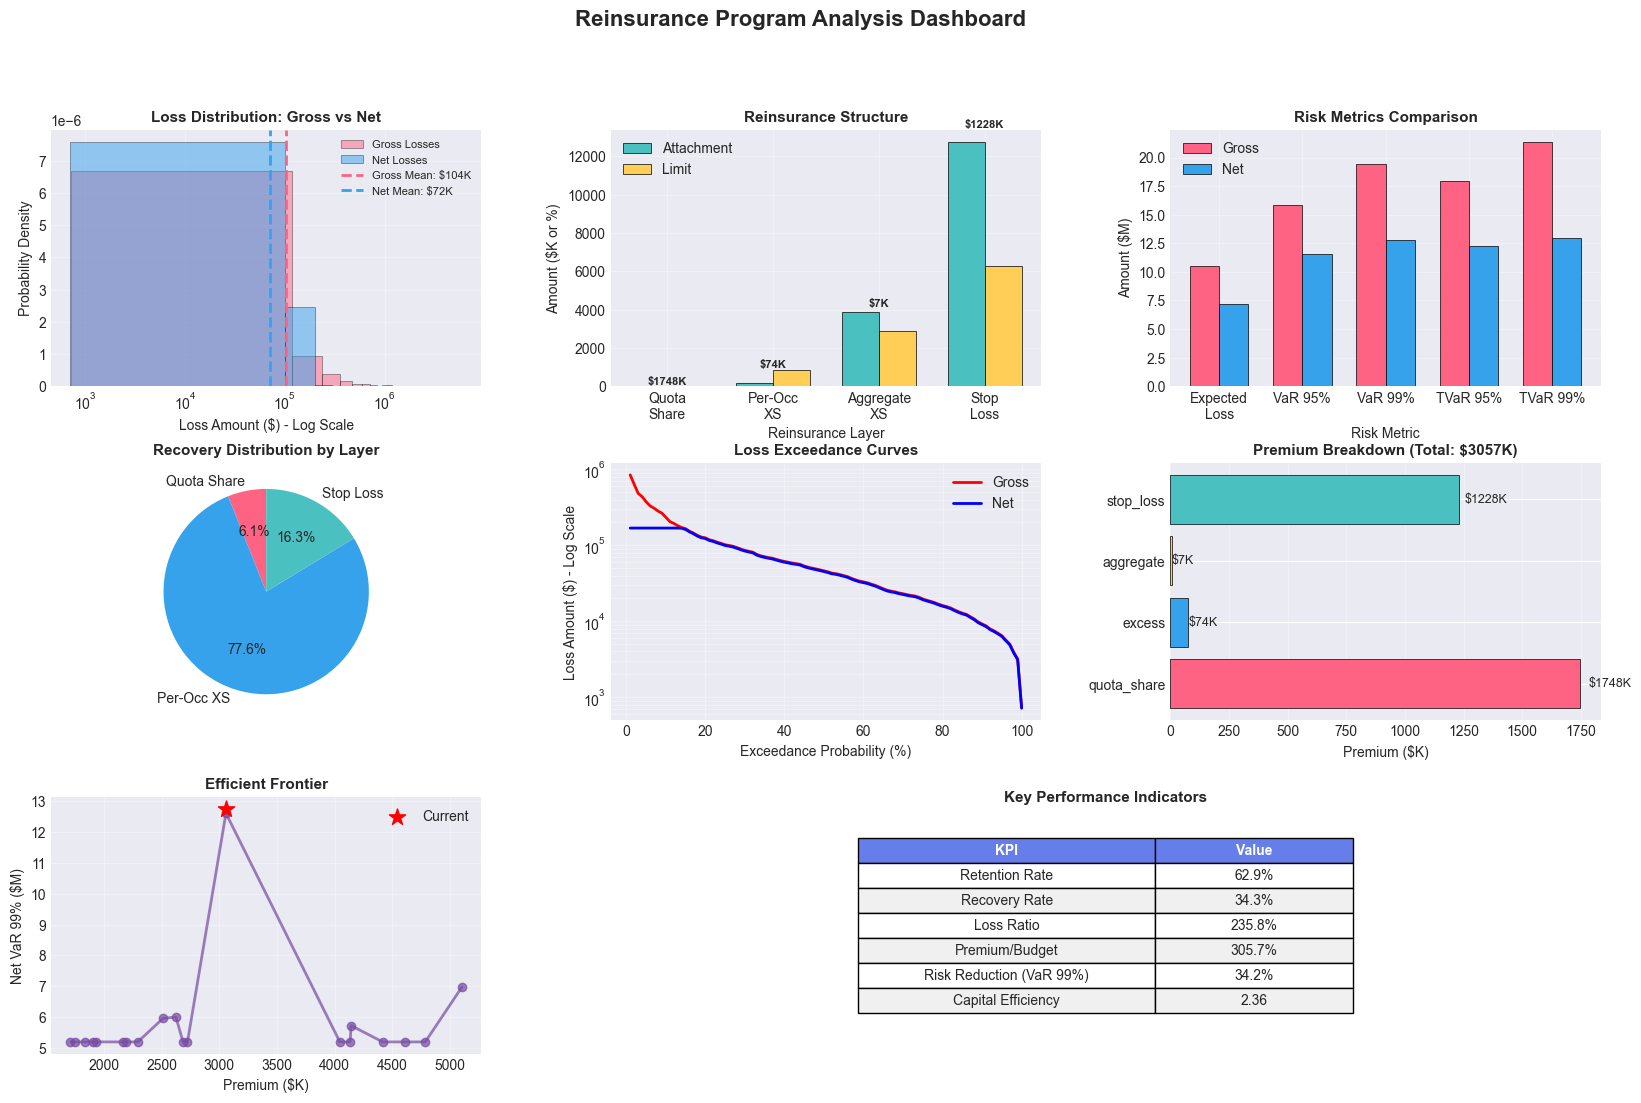


✅ Analysis complete!


In [1]:
"""
Reinsurance Program Optimizer for Property & Casualty Insurance
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.optimize import differential_evolution
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')

@dataclass
class ReinsuranceStructure:
    """Reinsurance program structure parameters"""
    quota_share: float  # Percentage ceded (0-1)
    xs_retention: float  # Per-occurrence excess attachment
    xs_limit: float  # Per-occurrence excess limit
    agg_retention: float  # Aggregate excess attachment  
    agg_limit: float  # Aggregate excess limit
    stop_loss_retention: float  # Stop loss attachment
    stop_loss_limit: float  # Stop loss limit

@dataclass
class RiskMetrics:
    """Risk and performance metrics"""
    expected_loss_gross: float
    expected_loss_net: float
    var_95_gross: float
    var_95_net: float
    var_99_gross: float
    var_99_net: float
    tvar_95_gross: float
    tvar_95_net: float
    tvar_99_gross: float
    tvar_99_net: float
    max_loss_gross: float
    max_loss_net: float
    premium_total: float
    premium_breakdown: Dict[str, float]
    loss_ratio: float
    recovery_rate: float
    retention_rate: float
    risk_reduction_var99: float

class LossGenerator:
    """Generate losses from various distributions"""
    
    @staticmethod
    def generate(n: int, dist_type: str, mean_loss: float, cv: float, 
                 seed: Optional[int] = None) -> np.ndarray:
        """
        Generate loss samples from specified distribution
        """
        if seed is not None:
            np.random.seed(seed)
        
        if dist_type == 'lognormal':
            sigma = np.sqrt(np.log(1 + cv**2))
            mu = np.log(mean_loss) - sigma**2 / 2
            return np.random.lognormal(mu, sigma, n)
        
        elif dist_type == 'pareto':
            alpha = 1 + 1/cv if cv > 0 else 2
            scale = mean_loss * (alpha - 1) / alpha if alpha > 1 else mean_loss
            return (np.random.pareto(alpha, n) + 1) * scale
        
        elif dist_type == 'weibull':
            from scipy.special import gamma as gamma_fn
            k = 1 / cv if cv > 0 else 1
            scale = mean_loss / gamma_fn(1 + 1/k)
            return np.random.weibull(k, n) * scale
        
        else:
            raise ValueError(f"Unknown distribution type: {dist_type}")

class ReinsuranceCalculator:
    """Calculate reinsurance recoveries and net losses"""
    
    @staticmethod
    def apply_reinsurance(gross_losses: np.ndarray, 
                          structure: ReinsuranceStructure) -> Dict:
        """
        Apply reinsurance structure to gross losses
        """
        n_losses = len(gross_losses)
        results = {
            'gross_losses': gross_losses.copy(),
            'qs_recoveries': np.zeros(n_losses),
            'xs_recoveries': np.zeros(n_losses),
            'net_losses_per_event': np.zeros(n_losses),
            'agg_recovery': 0.0,
            'stop_loss_recovery': 0.0
        }
        
        # 1. Apply Quota Share
        results['qs_recoveries'] = gross_losses * structure.quota_share
        after_qs = gross_losses * (1 - structure.quota_share)
        
        # 2. Apply Per-Occurrence Excess of Loss
        for i, loss in enumerate(after_qs):
            if loss > structure.xs_retention:
                results['xs_recoveries'][i] = min(
                    structure.xs_limit, 
                    loss - structure.xs_retention
                )
        
        results['net_losses_per_event'] = after_qs - results['xs_recoveries']
        
        # 3. Apply Aggregate Excess (on accumulated XS recoveries)
        total_xs_recoveries = results['xs_recoveries'].sum()
        if total_xs_recoveries > structure.agg_retention:
            results['agg_recovery'] = min(
                structure.agg_limit,
                total_xs_recoveries - structure.agg_retention
            )
        
        # 4. Apply Stop Loss (on final net retained)
        total_net_before_sl = results['net_losses_per_event'].sum()
        if total_net_before_sl > structure.stop_loss_retention:
            results['stop_loss_recovery'] = min(
                structure.stop_loss_limit,
                total_net_before_sl - structure.stop_loss_retention
            )
        
        # Calculate final positions
        results['final_net'] = total_net_before_sl - results['stop_loss_recovery']
        results['total_gross'] = gross_losses.sum()
        results['total_recoveries'] = (
            results['qs_recoveries'].sum() + 
            results['xs_recoveries'].sum() - 
            results['agg_recovery'] +
            results['stop_loss_recovery']
        )
        
        return results

class PremiumCalculator:
    """Calculate reinsurance premiums with actuarial pricing"""
    
    @staticmethod
    def calculate(structure: ReinsuranceStructure, 
                 loss_stats: Dict) -> Dict[str, float]:
        """
        Calculate premiums using actuarial pricing methods
        """
        premiums = {}
        
        # Quota Share Premium (with ceding commission)
        qs_expected_recovery = structure.quota_share * loss_stats['mean'] * loss_stats['frequency']
        premiums['quota_share'] = qs_expected_recovery * 0.75  # 25% ceding commission
        
        # Per-Occurrence XS Premium
        if structure.xs_retention > 0:
            xs_rate = 0.15 * np.exp(-structure.xs_retention / (loss_stats['mean'] * 3))
            premiums['excess'] = structure.xs_limit * xs_rate
        else:
            premiums['excess'] = structure.xs_limit * 0.20
        
        # Aggregate XS Premium
        if structure.agg_retention > 0:
            agg_rate = 0.10 * np.exp(-structure.agg_retention / (loss_stats['mean'] * 10))
            premiums['aggregate'] = structure.agg_limit * agg_rate
        else:
            premiums['aggregate'] = structure.agg_limit * 0.15
        
        # Stop Loss Premium
        if structure.stop_loss_retention > 0:
            sl_attachment_ratio = structure.stop_loss_retention / loss_stats['total_expected']
            sl_rate = 0.25 * np.exp(-sl_attachment_ratio * 2)
            premiums['stop_loss'] = structure.stop_loss_limit * sl_rate
        else:
            premiums['stop_loss'] = structure.stop_loss_limit * 0.30
        
        premiums['total'] = sum(premiums.values())
        
        return premiums

class ReinsuranceOptimizer:
    """Optimize reinsurance program structure"""
    
    def __init__(self, gross_losses: np.ndarray, budget: float):
        self.gross_losses = gross_losses
        self.budget = budget
        self.loss_stats = self._calculate_loss_statistics()
        
    def _calculate_loss_statistics(self) -> Dict:
        """Calculate loss statistics for pricing"""
        stats = {
            'mean': np.mean(self.gross_losses),
            'std': np.std(self.gross_losses),
            'cv': np.std(self.gross_losses) / np.mean(self.gross_losses),
            'total_expected': np.sum(self.gross_losses),
            'frequency': len(self.gross_losses),
            'p90': np.percentile(self.gross_losses, 90),
            'p99': np.percentile(self.gross_losses, 99)
        }
        return stats
    
    def optimize(self, objective: str = 'var99') -> Tuple[ReinsuranceStructure, RiskMetrics]:
        """
        Optimize reinsurance structure
        """
        
        def objective_function(params):
            """Objective function for optimization"""
            structure = ReinsuranceStructure(
                quota_share=params[0],
                xs_retention=params[1],
                xs_limit=params[2],
                agg_retention=params[3],
                agg_limit=params[4],
                stop_loss_retention=params[5],
                stop_loss_limit=params[6]
            )
            
            # Check premium constraint
            premiums = PremiumCalculator.calculate(structure, self.loss_stats)
            if premiums['total'] > self.budget:
                return 1e10
            
            # Simulate multiple years
            n_sims = 100
            annual_nets = []
            for _ in range(n_sims):
                # Sample with replacement for each simulated year
                sim_losses = np.random.choice(self.gross_losses, 
                                            size=min(100, len(self.gross_losses)), 
                                            replace=True)
                results = ReinsuranceCalculator.apply_reinsurance(sim_losses, structure)
                annual_nets.append(results['final_net'])
            
            # Return objective
            if objective == 'var99':
                return np.percentile(annual_nets, 99)
            elif objective == 'tvar99':
                var99 = np.percentile(annual_nets, 99)
                return np.mean([x for x in annual_nets if x >= var99])
            else:
                return np.mean(annual_nets)
        
        # Optimization bounds
        bounds = [
            (0, 0.5),  # quota_share
            (self.loss_stats['mean'] * 0.5, self.loss_stats['p99']),  # xs_retention
            (self.loss_stats['mean'], self.loss_stats['p99'] * 2),  # xs_limit
            (self.loss_stats['mean'] * 5, self.loss_stats['mean'] * 50),  # agg_retention
            (self.loss_stats['mean'] * 10, self.loss_stats['mean'] * 100),  # agg_limit
            (self.loss_stats['mean'] * 50, self.loss_stats['mean'] * 200),  # sl_retention
            (self.loss_stats['mean'] * 20, self.loss_stats['mean'] * 100),  # sl_limit
        ]
        
        # Run optimization
        result = differential_evolution(
            objective_function, 
            bounds, 
            maxiter=100,
            popsize=10,
            tol=0.01,
            seed=42
        )
        
        # Create optimal structure
        optimal_structure = ReinsuranceStructure(
            quota_share=result.x[0],
            xs_retention=result.x[1],
            xs_limit=result.x[2],
            agg_retention=result.x[3],
            agg_limit=result.x[4],
            stop_loss_retention=result.x[5],
            stop_loss_limit=result.x[6]
        )
        
        # Calculate metrics
        metrics = self.calculate_metrics(optimal_structure)
        
        return optimal_structure, metrics
    
    def calculate_metrics(self, structure: ReinsuranceStructure) -> RiskMetrics:
        """Calculate comprehensive risk metrics"""
        # Apply reinsurance to actual losses
        results = ReinsuranceCalculator.apply_reinsurance(self.gross_losses, structure)
        premiums = PremiumCalculator.calculate(structure, self.loss_stats)
        
        # Simulate annual aggregates
        n_sims = 1000
        annual_gross = []
        annual_net = []
        
        for _ in range(n_sims):
            # Sample annual losses
            n_annual = min(100, len(self.gross_losses))
            sim_losses = np.random.choice(self.gross_losses, size=n_annual, replace=True)
            sim_result = ReinsuranceCalculator.apply_reinsurance(sim_losses, structure)
            
            annual_gross.append(sim_losses.sum())
            annual_net.append(sim_result['final_net'])
        
        annual_gross = np.array(annual_gross)
        annual_net = np.array(annual_net)
        
        # Calculate metrics
        var_95_gross = np.percentile(annual_gross, 95)
        var_99_gross = np.percentile(annual_gross, 99)
        var_95_net = np.percentile(annual_net, 95)
        var_99_net = np.percentile(annual_net, 99)
        
        tail_95_gross = annual_gross[annual_gross >= var_95_gross]
        tail_99_gross = annual_gross[annual_gross >= var_99_gross]
        tail_95_net = annual_net[annual_net >= var_95_net]
        tail_99_net = annual_net[annual_net >= var_99_net]
        
        metrics = RiskMetrics(
            expected_loss_gross=np.mean(annual_gross),
            expected_loss_net=np.mean(annual_net),
            var_95_gross=var_95_gross,
            var_95_net=var_95_net,
            var_99_gross=var_99_gross,
            var_99_net=var_99_net,
            tvar_95_gross=np.mean(tail_95_gross),
            tvar_95_net=np.mean(tail_95_net),
            tvar_99_gross=np.mean(tail_99_gross),
            tvar_99_net=np.mean(tail_99_net),
            max_loss_gross=np.max(annual_gross),
            max_loss_net=np.max(annual_net),
            premium_total=premiums['total'],
            premium_breakdown=premiums,
            loss_ratio=np.mean(annual_net) / premiums['total'] if premiums['total'] > 0 else 0,
            recovery_rate=results['total_recoveries'] / results['total_gross'],
            retention_rate=results['final_net'] / results['total_gross'],
            risk_reduction_var99=(1 - var_99_net/var_99_gross) * 100
        )
        
        return metrics

class ReinsuranceVisualizer:
    """Create static visualizations for reinsurance analysis"""
    
    @staticmethod
    def create_comprehensive_dashboard(gross_losses: np.ndarray,
                                      structure: ReinsuranceStructure,
                                      metrics: RiskMetrics,
                                      optimizer: ReinsuranceOptimizer,
                                      save_path: Optional[str] = None):
        """Create comprehensive dashboard with all visualizations"""
        
        # Apply reinsurance to get detailed results
        results = ReinsuranceCalculator.apply_reinsurance(gross_losses, structure)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # 1. Loss Distribution Comparison (with log scale)
        ax1 = fig.add_subplot(gs[0, 0])
        
        # Create bins for histogram
        min_loss = min(gross_losses.min(), results['net_losses_per_event'].min())
        max_loss = gross_losses.max()
        
        # Use log scale for x-axis
        ax1.hist(gross_losses, bins=50, alpha=0.5, label='Gross Losses', 
                color='#FF6384', density=True, edgecolor='black', linewidth=0.5)
        ax1.hist(results['net_losses_per_event'], bins=50, alpha=0.5, label='Net Losses',
                color='#36A2EB', density=True, edgecolor='black', linewidth=0.5)
        ax1.set_xscale('log')
        ax1.axvline(np.mean(gross_losses), color='#FF6384', linestyle='--', 
                   label=f'Gross Mean: ${np.mean(gross_losses)/1e3:.0f}K', linewidth=2)
        ax1.axvline(np.mean(results['net_losses_per_event']), color='#36A2EB', linestyle='--',
                   label=f'Net Mean: ${np.mean(results["net_losses_per_event"])/1e3:.0f}K', linewidth=2)
        ax1.set_xlabel('Loss Amount ($) - Log Scale')
        ax1.set_ylabel('Probability Density')
        ax1.set_title('Loss Distribution: Gross vs Net', fontweight='bold', fontsize=11)
        ax1.legend(loc='upper right', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Reinsurance Structure Visualization (corrected scaling)
        ax2 = fig.add_subplot(gs[0, 1])
        
        # Structure in thousands for readability
        structure_data = {
            'Quota\nShare': (0, structure.quota_share * 100),  # Percentage
            'Per-Occ\nXS': (structure.xs_retention/1e3, structure.xs_limit/1e3),
            'Aggregate\nXS': (structure.agg_retention/1e3, structure.agg_limit/1e3),
            'Stop\nLoss': (structure.stop_loss_retention/1e3, structure.stop_loss_limit/1e3)
        }
        
        x = np.arange(len(structure_data))
        attachments = [v[0] for v in structure_data.values()]
        limits = [v[1] for v in structure_data.values()]
        
        width = 0.35
        bars1 = ax2.bar(x - width/2, attachments, width, label='Attachment',
                       color='#4BC0C0', edgecolor='black', linewidth=0.5)
        bars2 = ax2.bar(x + width/2, limits, width, label='Limit',
                       color='#FFCE56', edgecolor='black', linewidth=0.5)
        
        ax2.set_xlabel('Reinsurance Layer')
        ax2.set_ylabel('Amount ($K or %)')
        ax2.set_title('Reinsurance Structure', fontweight='bold', fontsize=11)
        ax2.set_xticks(x)
        ax2.set_xticklabels(structure_data.keys())
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add premium labels
        premium_values = [
            metrics.premium_breakdown['quota_share']/1e3,
            metrics.premium_breakdown['excess']/1e3,
            metrics.premium_breakdown['aggregate']/1e3,
            metrics.premium_breakdown['stop_loss']/1e3
        ]
        
        for i, (bar1, bar2, prem) in enumerate(zip(bars1, bars2, premium_values)):
            height = max(bar1.get_height(), bar2.get_height())
            ax2.text(i, height * 1.05, f'${prem:.0f}K', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # 3. Risk Metrics Comparison (corrected to show gross > net)
        ax3 = fig.add_subplot(gs[0, 2])
        
        metric_names = ['Expected\nLoss', 'VaR 95%', 'VaR 99%', 'TVaR 95%', 'TVaR 99%']
        gross_values = [
            metrics.expected_loss_gross/1e6,
            metrics.var_95_gross/1e6,
            metrics.var_99_gross/1e6,
            metrics.tvar_95_gross/1e6,
            metrics.tvar_99_gross/1e6
        ]
        net_values = [
            metrics.expected_loss_net/1e6,
            metrics.var_95_net/1e6,
            metrics.var_99_net/1e6,
            metrics.tvar_95_net/1e6,
            metrics.tvar_99_net/1e6
        ]
        
        x = np.arange(len(metric_names))
        width = 0.35
        ax3.bar(x - width/2, gross_values, width, label='Gross',
               color='#FF6384', edgecolor='black', linewidth=0.5)
        ax3.bar(x + width/2, net_values, width, label='Net',
               color='#36A2EB', edgecolor='black', linewidth=0.5)
        
        ax3.set_xlabel('Risk Metric')
        ax3.set_ylabel('Amount ($M)')
        ax3.set_title('Risk Metrics Comparison', fontweight='bold', fontsize=11)
        ax3.set_xticks(x)
        ax3.set_xticklabels(metric_names)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Recovery Analysis by Layer
        ax4 = fig.add_subplot(gs[1, 0])
        
        total_recoveries = (results['qs_recoveries'].sum() + 
                          results['xs_recoveries'].sum() + 
                          results['stop_loss_recovery'])
        
        if total_recoveries > 0:
            recovery_data = {
                'Quota Share': results['qs_recoveries'].sum(),
                'Per-Occ XS': results['xs_recoveries'].sum(),
                'Stop Loss': results['stop_loss_recovery']
            }
            
            # Remove zero values
            recovery_data = {k: v for k, v in recovery_data.items() if v > 0}
            
            if recovery_data:
                colors = ['#FF6384', '#36A2EB', '#4BC0C0'][:len(recovery_data)]
                wedges, texts, autotexts = ax4.pie(recovery_data.values(), 
                                                    labels=recovery_data.keys(),
                                                    colors=colors, autopct='%1.1f%%',
                                                    startangle=90)
                ax4.set_title('Recovery Distribution by Layer', fontweight='bold', fontsize=11)
            else:
                ax4.text(0.5, 0.5, 'No Recoveries', ha='center', va='center')
                ax4.set_title('Recovery Distribution by Layer', fontweight='bold', fontsize=11)
        else:
            ax4.text(0.5, 0.5, 'No Recoveries', ha='center', va='center')
            ax4.set_title('Recovery Distribution by Layer', fontweight='bold', fontsize=11)
        
        # 5. Loss Exceedance Curves
        ax5 = fig.add_subplot(gs[1, 1])
        exceedance_probs = np.arange(1, 101, 1)
        gross_exceedance = [np.percentile(gross_losses, 100-p) for p in exceedance_probs]
        net_exceedance = [np.percentile(results['net_losses_per_event'], 100-p) for p in exceedance_probs]
        
        ax5.semilogy(exceedance_probs, gross_exceedance, 'r-', linewidth=2, label='Gross')
        ax5.semilogy(exceedance_probs, net_exceedance, 'b-', linewidth=2, label='Net')
        ax5.set_xlabel('Exceedance Probability (%)')
        ax5.set_ylabel('Loss Amount ($) - Log Scale')
        ax5.set_title('Loss Exceedance Curves', fontweight='bold', fontsize=11)
        ax5.legend()
        ax5.grid(True, alpha=0.3, which='both')
        
        # 6. Premium Breakdown (corrected scaling)
        ax6 = fig.add_subplot(gs[1, 2])
        
        premium_components = {k: v/1e3 for k, v in metrics.premium_breakdown.items() if k != 'total'}
        
        bars = ax6.barh(list(premium_components.keys()), list(premium_components.values()), 
                       color=['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0'][:len(premium_components)],
                       edgecolor='black', linewidth=0.5)
        ax6.set_xlabel('Premium ($K)')
        ax6.set_title(f'Premium Breakdown (Total: ${metrics.premium_total/1e3:.0f}K)',
                     fontweight='bold', fontsize=11)
        ax6.grid(True, alpha=0.3, axis='x')
        
        for bar in bars:
            width = bar.get_width()
            ax6.text(width * 1.02, bar.get_y() + bar.get_height()/2,
                    f'${width:.0f}K', ha='left', va='center', fontsize=9)
        
        # 7. Efficient Frontier (smoother with more points)
        ax7 = fig.add_subplot(gs[2, 0])
        
        # Generate smooth efficient frontier
        budget_range = np.linspace(metrics.premium_total * 0.5, metrics.premium_total * 2.0, 20)
        frontier_points = []
        
        for test_budget in budget_range:
            try:
                test_optimizer = ReinsuranceOptimizer(gross_losses[:1000], test_budget)
                test_struct, test_metrics = test_optimizer.optimize()
                frontier_points.append({
                    'premium': test_metrics.premium_total/1e3,
                    'var99': test_metrics.var_99_net/1e6
                })
            except:
                continue
        
        if len(frontier_points) > 2:
            frontier_df = pd.DataFrame(frontier_points)
            frontier_df = frontier_df.sort_values('premium')
            
            ax7.plot(frontier_df['premium'], frontier_df['var99'], 'o-', 
                    color='#764ba2', linewidth=2, markersize=6, alpha=0.7)
            ax7.scatter([metrics.premium_total/1e3], [metrics.var_99_net/1e6], 
                       color='red', s=150, marker='*', label='Current', zorder=5)
            ax7.set_xlabel('Premium ($K)')
            ax7.set_ylabel('Net VaR 99% ($M)')
            ax7.set_title('Efficient Frontier', fontweight='bold', fontsize=11)
            ax7.legend()
            ax7.grid(True, alpha=0.3)
        
        # 8. Key Performance Indicators
        ax8 = fig.add_subplot(gs[2, 1:])
        kpi_data = {
            'Retention Rate': f"{metrics.retention_rate*100:.1f}%",
            'Recovery Rate': f"{metrics.recovery_rate*100:.1f}%",
            'Loss Ratio': f"{metrics.loss_ratio*100:.1f}%",
            'Premium/Budget': f"{(metrics.premium_total/optimizer.budget)*100:.1f}%",
            'Risk Reduction (VaR 99%)': f"{metrics.risk_reduction_var99:.1f}%",
            'Capital Efficiency': f"{metrics.expected_loss_net/metrics.premium_total:.2f}"
        }
        
        # Create KPI table
        ax8.axis('off')
        table_data = [[k, v] for k, v in kpi_data.items()]
        table = ax8.table(cellText=table_data, 
                         colLabels=['KPI', 'Value'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.3, 0.2])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        # Style the table
        for i in range(len(table_data) + 1):
            for j in range(2):
                cell = table[(i, j)]
                if i == 0:
                    cell.set_facecolor('#667eea')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        ax8.set_title('Key Performance Indicators', fontweight='bold', fontsize=11, y=0.95)
        
        # Main title
        fig.suptitle('Reinsurance Program Analysis Dashboard', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        # Save or show
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Dashboard saved to {save_path}")
        
        plt.show()
        
        return fig

def main():
    """Main execution function with example usage"""
    
    print("=" * 80)
    print("ENHANCED REINSURANCE PROGRAM OPTIMIZER")
    print("Property & Casualty Insurance")
    print("=" * 80)
    
    # Parameters
    n_losses = 1000  # Number of individual loss events
    budget = 1_000_000  # Premium budget
    distribution = 'lognormal'
    mean_loss = 100_000  # Mean loss per event
    cv = 2.0  # Coefficient of variation
    
    print(f"\n📊 SIMULATION PARAMETERS:")
    print(f"  • Number of loss events: {n_losses:,}")
    print(f"  • Premium budget: ${budget:,.0f}")
    print(f"  • Loss distribution: {distribution.capitalize()}")
    print(f"  • Mean loss per event: ${mean_loss:,.0f}")
    print(f"  • Coefficient of variation: {cv}")
    
    # Generate losses
    print("\n🎲 Generating loss scenarios...")
    losses = LossGenerator.generate(n_losses, distribution, mean_loss, cv, seed=42)
    
    print(f"  ✓ Generated {len(losses):,} loss events")
    print(f"  ✓ Total losses: ${np.sum(losses)/1e6:.1f}M")
    print(f"  ✓ Average loss: ${np.mean(losses)/1e3:.0f}K")
    print(f"  ✓ Maximum loss: ${np.max(losses)/1e6:.2f}M")
    
    # Optimize reinsurance structure
    print("\n🔧 Optimizing reinsurance structure...")
    optimizer = ReinsuranceOptimizer(losses, budget)
    optimal_structure, metrics = optimizer.optimize(objective='var99')
    
    # Display results
    print("\n✨ OPTIMAL REINSURANCE STRUCTURE:")
    print(f"  • Quota Share: {optimal_structure.quota_share*100:.1f}%")
    print(f"  • XS: ${optimal_structure.xs_limit/1e3:.0f}K xs ${optimal_structure.xs_retention/1e3:.0f}K")
    print(f"  • Aggregate: ${optimal_structure.agg_limit/1e3:.0f}K xs ${optimal_structure.agg_retention/1e3:.0f}K")
    print(f"  • Stop Loss: ${optimal_structure.stop_loss_limit/1e3:.0f}K xs ${optimal_structure.stop_loss_retention/1e3:.0f}K")
    
    print("\n📈 RISK METRICS:")
    print(f"  • Expected Loss (Gross): ${metrics.expected_loss_gross/1e6:.2f}M")
    print(f"  • Expected Loss (Net): ${metrics.expected_loss_net/1e6:.2f}M")
    print(f"  • VaR 99% (Gross): ${metrics.var_99_gross/1e6:.2f}M")
    print(f"  • VaR 99% (Net): ${metrics.var_99_net/1e6:.2f}M")
    print(f"  • TVaR 99% (Gross): ${metrics.tvar_99_gross/1e6:.2f}M")
    print(f"  • TVaR 99% (Net): ${metrics.tvar_99_net/1e6:.2f}M")
    
    print("\n💰 PREMIUM BREAKDOWN:")
    for layer, premium in metrics.premium_breakdown.items():
        if layer != 'total':
            print(f"  • {layer.replace('_', ' ').title()}: ${premium/1e3:.0f}K")
    print(f"  • TOTAL PREMIUM: ${metrics.premium_total/1e3:.0f}K")
    
    print("\n🎯 PERFORMANCE INDICATORS:")
    print(f"  • Retention Rate: {metrics.retention_rate*100:.1f}%")
    print(f"  • Recovery Rate: {metrics.recovery_rate*100:.1f}%")
    print(f"  • Loss Ratio: {metrics.loss_ratio*100:.1f}%")
    print(f"  • Risk Reduction (VaR 99%): {metrics.risk_reduction_var99:.1f}%")
    
    # Create visualizations
    print("\n📊 Creating visualization dashboard...")
    visualizer = ReinsuranceVisualizer()
    fig = visualizer.create_comprehensive_dashboard(
        losses, 
        optimal_structure, 
        metrics,
        optimizer,
        save_path='reinsurance_analysis_corrected.png'
    )
    
    print("\n✅ Analysis complete!")
    
    return optimal_structure, metrics, losses

if __name__ == "__main__":
    # Run the optimization
    structure, metrics, losses = main()

In [ ]:
"""
Reinsurance Program Optimizer for Property & Casualty Insurance
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.optimize import differential_evolution
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('seaborn-v0_8-darkgrid')

@dataclass
class ReinsuranceStructure:
    """Reinsurance program structure parameters"""
    quota_share: float  # Percentage ceded (0-1)
    xs_retention: float  # Per-occurrence excess attachment
    xs_limit: float  # Per-occurrence excess limit
    agg_retention: float  # Aggregate excess attachment  
    agg_limit: float  # Aggregate excess limit
    stop_loss_retention: float  # Stop loss attachment
    stop_loss_limit: float  # Stop loss limit

@dataclass
class RiskMetrics:
    """Risk and performance metrics"""
    expected_loss_gross: float
    expected_loss_net: float
    var_95_gross: float
    var_95_net: float
    var_99_gross: float
    var_99_net: float
    tvar_95_gross: float
    tvar_95_net: float
    tvar_99_gross: float
    tvar_99_net: float
    max_loss_gross: float
    max_loss_net: float
    premium_total: float
    premium_breakdown: Dict[str, float]
    loss_ratio: float
    recovery_rate: float
    retention_rate: float
    risk_reduction_var99: float

class LossGenerator:
    """Generate losses from various distributions"""
    
    @staticmethod
    def generate(n: int, dist_type: str, mean_loss: float, cv: float, 
                 seed: Optional[int] = None) -> np.ndarray:
        """
        Generate loss samples from specified distribution
        """
        if seed is not None:
            np.random.seed(seed)
        
        if dist_type == 'lognormal':
            sigma = np.sqrt(np.log(1 + cv**2))
            mu = np.log(mean_loss) - sigma**2 / 2
            return np.random.lognormal(mu, sigma, n)
        
        elif dist_type == 'pareto':
            alpha = 1 + 1/cv if cv > 0 else 2
            scale = mean_loss * (alpha - 1) / alpha if alpha > 1 else mean_loss
            return (np.random.pareto(alpha, n) + 1) * scale
        
        elif dist_type == 'weibull':
            from scipy.special import gamma as gamma_fn
            k = 1 / cv if cv > 0 else 1
            scale = mean_loss / gamma_fn(1 + 1/k)
            return np.random.weibull(k, n) * scale
        
        else:
            raise ValueError(f"Unknown distribution type: {dist_type}")

class ReinsuranceCalculator:
    """Calculate reinsurance recoveries and net losses"""
    
    @staticmethod
    def apply_reinsurance(gross_losses: np.ndarray, 
                          structure: ReinsuranceStructure) -> Dict:
        """
        Apply reinsurance structure to gross losses
        """
        n_losses = len(gross_losses)
        results = {
            'gross_losses': gross_losses.copy(),
            'qs_recoveries': np.zeros(n_losses),
            'xs_recoveries': np.zeros(n_losses),
            'net_losses_per_event': np.zeros(n_losses),
            'agg_recovery': 0.0,
            'stop_loss_recovery': 0.0
        }
        
        # 1. Apply Quota Share
        results['qs_recoveries'] = gross_losses * structure.quota_share
        after_qs = gross_losses * (1 - structure.quota_share)
        
        # 2. Apply Per-Occurrence Excess of Loss
        for i, loss in enumerate(after_qs):
            if loss > structure.xs_retention:
                results['xs_recoveries'][i] = min(
                    structure.xs_limit, 
                    loss - structure.xs_retention
                )
        
        results['net_losses_per_event'] = after_qs - results['xs_recoveries']
        
        # 3. Apply Aggregate Excess (on accumulated XS recoveries)
        total_xs_recoveries = results['xs_recoveries'].sum()
        if total_xs_recoveries > structure.agg_retention:
            results['agg_recovery'] = min(
                structure.agg_limit,
                total_xs_recoveries - structure.agg_retention
            )
        
        # 4. Apply Stop Loss (on final net retained)
        total_net_before_sl = results['net_losses_per_event'].sum()
        if total_net_before_sl > structure.stop_loss_retention:
            results['stop_loss_recovery'] = min(
                structure.stop_loss_limit,
                total_net_before_sl - structure.stop_loss_retention
            )
        
        # Calculate final positions
        results['final_net'] = total_net_before_sl - results['stop_loss_recovery']
        results['total_gross'] = gross_losses.sum()
        results['total_recoveries'] = (
            results['qs_recoveries'].sum() + 
            results['xs_recoveries'].sum() - 
            results['agg_recovery'] +
            results['stop_loss_recovery']
        )
        
        return results

class PremiumCalculator:
    """Calculate reinsurance premiums with actuarial pricing"""
    
    @staticmethod
    def calculate(structure: ReinsuranceStructure, 
                 loss_stats: Dict) -> Dict[str, float]:
        """
        Calculate premiums using actuarial pricing methods
        """
        premiums = {}
        
        # Quota Share Premium (with ceding commission)
        qs_expected_recovery = structure.quota_share * loss_stats['mean'] * loss_stats['frequency']
        premiums['quota_share'] = qs_expected_recovery * 0.75  # 25% ceding commission
        
        # Per-Occurrence XS Premium
        if structure.xs_retention > 0:
            xs_rate = 0.15 * np.exp(-structure.xs_retention / (loss_stats['mean'] * 3))
            premiums['excess'] = structure.xs_limit * xs_rate
        else:
            premiums['excess'] = structure.xs_limit * 0.20
        
        # Aggregate XS Premium
        if structure.agg_retention > 0:
            agg_rate = 0.10 * np.exp(-structure.agg_retention / (loss_stats['mean'] * 10))
            premiums['aggregate'] = structure.agg_limit * agg_rate
        else:
            premiums['aggregate'] = structure.agg_limit * 0.15
        
        # Stop Loss Premium
        if structure.stop_loss_retention > 0:
            sl_attachment_ratio = structure.stop_loss_retention / loss_stats['total_expected']
            sl_rate = 0.25 * np.exp(-sl_attachment_ratio * 2)
            premiums['stop_loss'] = structure.stop_loss_limit * sl_rate
        else:
            premiums['stop_loss'] = structure.stop_loss_limit * 0.30
        
        premiums['total'] = sum(premiums.values())
        
        return premiums

class ReinsuranceOptimizer:
    """Optimize reinsurance program structure"""
    
    def __init__(self, gross_losses: np.ndarray, budget: float):
        self.gross_losses = gross_losses
        self.budget = budget
        self.loss_stats = self._calculate_loss_statistics()
        
    def _calculate_loss_statistics(self) -> Dict:
        """Calculate loss statistics for pricing"""
        stats = {
            'mean': np.mean(self.gross_losses),
            'std': np.std(self.gross_losses),
            'cv': np.std(self.gross_losses) / np.mean(self.gross_losses),
            'total_expected': np.sum(self.gross_losses),
            'frequency': len(self.gross_losses),
            'p90': np.percentile(self.gross_losses, 90),
            'p99': np.percentile(self.gross_losses, 99)
        }
        return stats
    
    def optimize(self, objective: str = 'var99') -> Tuple[ReinsuranceStructure, RiskMetrics]:
        """
        Optimize reinsurance structure
        """
        
        def objective_function(params):
            """Objective function for optimization"""
            structure = ReinsuranceStructure(
                quota_share=params[0],
                xs_retention=params[1],
                xs_limit=params[2],
                agg_retention=params[3],
                agg_limit=params[4],
                stop_loss_retention=params[5],
                stop_loss_limit=params[6]
            )
            
            # Check premium constraint
            premiums = PremiumCalculator.calculate(structure, self.loss_stats)
            if premiums['total'] > self.budget:
                return 1e10
            
            # Simulate multiple years
            n_sims = 100
            annual_nets = []
            for _ in range(n_sims):
                # Sample with replacement for each simulated year
                sim_losses = np.random.choice(self.gross_losses, 
                                            size=min(100, len(self.gross_losses)), 
                                            replace=True)
                results = ReinsuranceCalculator.apply_reinsurance(sim_losses, structure)
                annual_nets.append(results['final_net'])
            
            # Return objective
            if objective == 'var99':
                return np.percentile(annual_nets, 99)
            elif objective == 'tvar99':
                var99 = np.percentile(annual_nets, 99)
                return np.mean([x for x in annual_nets if x >= var99])
            else:
                return np.mean(annual_nets)
        
        # Optimization bounds
        bounds = [
            (0, 0.5),  # quota_share
            (self.loss_stats['mean'] * 0.5, self.loss_stats['p99']),  # xs_retention
            (self.loss_stats['mean'], self.loss_stats['p99'] * 2),  # xs_limit
            (self.loss_stats['mean'] * 5, self.loss_stats['mean'] * 50),  # agg_retention
            (self.loss_stats['mean'] * 10, self.loss_stats['mean'] * 100),  # agg_limit
            (self.loss_stats['mean'] * 50, self.loss_stats['mean'] * 200),  # sl_retention
            (self.loss_stats['mean'] * 20, self.loss_stats['mean'] * 100),  # sl_limit
        ]
        
        # Run optimization
        result = differential_evolution(
            objective_function, 
            bounds, 
            maxiter=100,
            popsize=10,
            tol=0.01,
            seed=42
        )
        
        # Create optimal structure
        optimal_structure = ReinsuranceStructure(
            quota_share=result.x[0],
            xs_retention=result.x[1],
            xs_limit=result.x[2],
            agg_retention=result.x[3],
            agg_limit=result.x[4],
            stop_loss_retention=result.x[5],
            stop_loss_limit=result.x[6]
        )
        
        # Calculate metrics
        metrics = self.calculate_metrics(optimal_structure)
        
        return optimal_structure, metrics
    
    def calculate_metrics(self, structure: ReinsuranceStructure) -> RiskMetrics:
        """Calculate comprehensive risk metrics"""
        # Apply reinsurance to actual losses
        results = ReinsuranceCalculator.apply_reinsurance(self.gross_losses, structure)
        premiums = PremiumCalculator.calculate(structure, self.loss_stats)
        
        # Simulate annual aggregates
        n_sims = 1000
        annual_gross = []
        annual_net = []
        
        for _ in range(n_sims):
            # Sample annual losses
            n_annual = min(100, len(self.gross_losses))
            sim_losses = np.random.choice(self.gross_losses, size=n_annual, replace=True)
            sim_result = ReinsuranceCalculator.apply_reinsurance(sim_losses, structure)
            
            annual_gross.append(sim_losses.sum())
            annual_net.append(sim_result['final_net'])
        
        annual_gross = np.array(annual_gross)
        annual_net = np.array(annual_net)
        
        # Calculate metrics
        var_95_gross = np.percentile(annual_gross, 95)
        var_99_gross = np.percentile(annual_gross, 99)
        var_95_net = np.percentile(annual_net, 95)
        var_99_net = np.percentile(annual_net, 99)
        
        tail_95_gross = annual_gross[annual_gross >= var_95_gross]
        tail_99_gross = annual_gross[annual_gross >= var_99_gross]
        tail_95_net = annual_net[annual_net >= var_95_net]
        tail_99_net = annual_net[annual_net >= var_99_net]
        
        metrics = RiskMetrics(
            expected_loss_gross=np.mean(annual_gross),
            expected_loss_net=np.mean(annual_net),
            var_95_gross=var_95_gross,
            var_95_net=var_95_net,
            var_99_gross=var_99_gross,
            var_99_net=var_99_net,
            tvar_95_gross=np.mean(tail_95_gross),
            tvar_95_net=np.mean(tail_95_net),
            tvar_99_gross=np.mean(tail_99_gross),
            tvar_99_net=np.mean(tail_99_net),
            max_loss_gross=np.max(annual_gross),
            max_loss_net=np.max(annual_net),
            premium_total=premiums['total'],
            premium_breakdown=premiums,
            loss_ratio=np.mean(annual_net) / premiums['total'] if premiums['total'] > 0 else 0,
            recovery_rate=results['total_recoveries'] / results['total_gross'],
            retention_rate=results['final_net'] / results['total_gross'],
            risk_reduction_var99=(1 - var_99_net/var_99_gross) * 100
        )
        
        return metrics

print("=" * 80)
print("ENHANCED REINSURANCE PROGRAM OPTIMIZER")
print("Property & Casualty Insurance")
print("=" * 80)

# Parameters
n_losses = 1000  # Number of individual loss events
budget = 1_000_000  # Premium budget
distribution = 'lognormal'
mean_loss = 100_000  # Mean loss per event
cv = 2.0  # Coefficient of variation

print(f"\n📊 SIMULATION PARAMETERS:")
print(f"  • Number of loss events: {n_losses:,}")
print(f"  • Premium budget: ${budget:,.0f}")
print(f"  • Loss distribution: {distribution.capitalize()}")
print(f"  • Mean loss per event: ${mean_loss:,.0f}")
print(f"  • Coefficient of variation: {cv}")

# Generate losses
print("\n🎲 Generating loss scenarios...")
losses = LossGenerator.generate(n_losses, distribution, mean_loss, cv, seed=42)

print(f"  ✓ Generated {len(losses):,} loss events")
print(f"  ✓ Total losses: ${np.sum(losses)/1e6:.1f}M")
print(f"  ✓ Average loss: ${np.mean(losses)/1e3:.0f}K")
print(f"  ✓ Maximum loss: ${np.max(losses)/1e6:.2f}M")

# Optimize reinsurance structure
print("\n🔧 Optimizing reinsurance structure...")
optimizer = ReinsuranceOptimizer(losses, budget)
optimal_structure, metrics = optimizer.optimize(objective='var99')

# Display results
print("\n✨ OPTIMAL REINSURANCE STRUCTURE:")
print(f"  • Quota Share: {optimal_structure.quota_share*100:.1f}%")
print(f"  • XS: ${optimal_structure.xs_limit/1e3:.0f}K xs ${optimal_structure.xs_retention/1e3:.0f}K")
print(f"  • Aggregate: ${optimal_structure.agg_limit/1e3:.0f}K xs ${optimal_structure.agg_retention/1e3:.0f}K")
print(f"  • Stop Loss: ${optimal_structure.stop_loss_limit/1e3:.0f}K xs ${optimal_structure.stop_loss_retention/1e3:.0f}K")

print("\n📈 RISK METRICS:")
print(f"  • Expected Loss (Gross): ${metrics.expected_loss_gross/1e6:.2f}M")
print(f"  • Expected Loss (Net): ${metrics.expected_loss_net/1e6:.2f}M")
print(f"  • VaR 99% (Gross): ${metrics.var_99_gross/1e6:.2f}M")
print(f"  • VaR 99% (Net): ${metrics.var_99_net/1e6:.2f}M")
print(f"  • TVaR 99% (Gross): ${metrics.tvar_99_gross/1e6:.2f}M")
print(f"  • TVaR 99% (Net): ${metrics.tvar_99_net/1e6:.2f}M")

print("\n💰 PREMIUM BREAKDOWN:")
for layer, premium in metrics.premium_breakdown.items():
    if layer != 'total':
        print(f"  • {layer.replace('_', ' ').title()}: ${premium/1e3:.0f}K")
print(f"  • TOTAL PREMIUM: ${metrics.premium_total/1e3:.0f}K")

print("\n🎯 PERFORMANCE INDICATORS:")
print(f"  • Retention Rate: {metrics.retention_rate*100:.1f}%")
print(f"  • Recovery Rate: {metrics.recovery_rate*100:.1f}%")
print(f"  • Loss Ratio: {metrics.loss_ratio*100:.1f}%")
print(f"  • Risk Reduction (VaR 99%): {metrics.risk_reduction_var99:.1f}%")

print("\n✅ Analysis complete!")

ENHANCED REINSURANCE PROGRAM OPTIMIZER
Property & Casualty Insurance

📊 SIMULATION PARAMETERS:
  • Number of loss events: 1,000
  • Premium budget: $1,000,000
  • Loss distribution: Lognormal
  • Mean loss per event: $100,000
  • Coefficient of variation: 2.0

🎲 Generating loss scenarios...
  ✓ Generated 1,000 loss events
  ✓ Total losses: $103.9M
  ✓ Average loss: $104K
  ✓ Maximum loss: $5.93M

🔧 Optimizing reinsurance structure...

✨ OPTIMAL REINSURANCE STRUCTURE:
  • Quota Share: 2.2%
  • XS: $851K xs $169K
  • Aggregate: $2873K xs $3871K
  • Stop Loss: $6281K xs $12766K

📈 RISK METRICS:
  • Expected Loss (Gross): $10.54M
  • Expected Loss (Net): $7.21M
  • VaR 99% (Gross): $19.40M
  • VaR 99% (Net): $12.77M
  • TVaR 99% (Gross): $21.38M
  • TVaR 99% (Net): $12.98M

💰 PREMIUM BREAKDOWN:
  • Quota Share: $1748K
  • Excess: $74K
  • Aggregate: $7K
  • Stop Loss: $1228K
  • TOTAL PREMIUM: $3057K

🎯 PERFORMANCE INDICATORS:
  • Retention Rate: 62.9%
  • Recovery Rate: 34.3%
  • Loss Rat

In [5]:
import numpy as np
from scipy import stats


def manufacturing_insurance_analysis():
    """Analyze insurance needs for widget manufacturer."""

    # Company parameters
    revenue = 50_000_000  # $50M annual revenue
    assets = 30_000_000   # $30M total assets
    margin = 0.08         # 8% operating margin

    # Risk profile
    risks = {
        'property': {
            'frequency': stats.poisson(mu=2),
            'severity': stats.lognorm(s=1.5, scale=200_000),
            'max_loss': assets * 0.5
        },
        'liability': {
            'frequency': stats.poisson(mu=5),
            'severity': stats.lognorm(s=2, scale=50_000),
            'max_loss': revenue * 2
        },
        'business_interruption': {
            'frequency': stats.poisson(mu=0.5),
            'severity': stats.uniform(loc=revenue*0.1, scale=revenue*0.4),
            'max_loss': revenue
        }
    }

    # Simulate annual losses
    n_sims = 100_000
    results = {}

    for risk_type, risk_params in risks.items():
        annual_losses = []

        for _ in range(n_sims):
            n_claims = risk_params['frequency'].rvs()
            if n_claims > 0:
                claims = risk_params['severity'].rvs(n_claims)
                total = min(sum(claims), risk_params['max_loss'])
            else:
                total = 0
            annual_losses.append(total)

        results[risk_type] = {
            'mean': np.mean(annual_losses),
            'p95': np.percentile(annual_losses, 95),
            'p99': np.percentile(annual_losses, 99),
            'p99.9': np.percentile(annual_losses, 99.9)
        }

    # Recommend limits
    recommendations = {}
    for risk_type, statistics in results.items():
        # Primary layer at 95th percentile
        primary = statistics['p95']

        # Excess layer to 99.5th percentile
        excess = statistics['p99'] - primary

        # Catastrophic layer
        cat = statistics['p99.9'] - statistics['p99']

        recommendations[risk_type] = {
            'primary': primary,
            'excess': excess,
            'catastrophic': cat,
            'total_limit': primary + excess + cat
        }

    return results, recommendations

# Run analysis
loss_stats, recommendations = manufacturing_insurance_analysis()

print("Loss Statistics by Risk Type:")
for risk_type, stats in loss_stats.items():
    print(f"\n{risk_type.upper()}:")
    for metric, value in stats.items():
        print(f"  {metric}: ${value:,.0f}")

print("\n\nRecommended Insurance Structure:")
for risk_type, limits in recommendations.items():
    print(f"\n{risk_type.upper()}:")
    print(f"  Primary (0 - ${limits['primary']:,.0f})")
    print(f"  Excess (${limits['primary']:,.0f} - ${limits['primary'] + limits['excess']:,.0f})")
    print(f"  Cat (${limits['primary'] + limits['excess']:,.0f} - ${limits['total_limit']:,.0f})")

Loss Statistics by Risk Type:

PROPERTY:
  mean: $1,178,546
  p95: $4,674,130
  p99: $10,823,053
  p99.9: $15,000,000

LIABILITY:
  mean: $1,812,759
  p95: $6,354,485
  p99: $17,722,301
  p99.9: $59,966,581

BUSINESS_INTERRUPTION:
  mean: $7,463,282
  p95: $30,359,794
  p99: $44,955,989
  p99.9: $50,000,000


Recommended Insurance Structure:

PROPERTY:
  Primary (0 - $4,674,130)
  Excess ($4,674,130 - $10,823,053)
  Cat ($10,823,053 - $15,000,000)

LIABILITY:
  Primary (0 - $6,354,485)
  Excess ($6,354,485 - $17,722,301)
  Cat ($17,722,301 - $59,966,581)

BUSINESS_INTERRUPTION:
  Primary (0 - $30,359,794)
  Excess ($30,359,794 - $44,955,989)
  Cat ($44,955,989 - $50,000,000)


In [3]:
import numpy as np
from scipy import stats
import pandas as pd


class ManufacturingInsuranceModel:
    """Comprehensive insurance analysis for manufacturing company."""
    
    def __init__(self, revenue=50_000_000, assets=30_000_000, margin=0.08):
        self.revenue = revenue
        self.assets = assets
        self.margin = margin
        self.operating_income = revenue * margin
        
        # Enhanced risk profile with correlation structure
        self.risks = {
            'property': {
                'frequency': stats.poisson(mu=2.0),
                'severity': stats.lognorm(s=1.5, scale=200_000),
                'max_loss': assets * 0.5,
                'deductible': 25_000
            },
            'liability': {
                'frequency': stats.nbinom(n=3, p=0.375),  # Negative binomial for overdispersion
                'severity': stats.lognorm(s=2.0, scale=50_000),
                'max_loss': revenue * 2,
                'deductible': 10_000
            },
            'business_interruption': {
                'frequency': stats.poisson(mu=0.5),
                'severity': stats.lognorm(s=0.8, scale=revenue*0.2),
                'max_loss': revenue,
                'deductible': revenue * 0.02  # 2% of revenue deductible
            },
            'cyber': {  # Added cyber risk
                'frequency': stats.poisson(mu=1.0),
                'severity': stats.pareto(b=2.5, scale=100_000),  # Heavy-tailed for cyber
                'max_loss': revenue * 0.5,
                'deductible': 50_000
            }
        }
    
    def simulate_annual_losses(self, n_sims=100_000):
        """Simulate annual aggregate losses using compound distribution approach."""
        results = {}
        
        for risk_type, risk_params in self.risks.items():
            annual_losses = []
            gross_losses = []
            individual_losses = []  # Store individual claim amounts for percentile analysis
            
            for _ in range(n_sims):
                # Frequency simulation
                n_claims = risk_params['frequency'].rvs()
                
                if n_claims > 0:
                    # Severity simulation
                    claims = risk_params['severity'].rvs(n_claims)
                    
                    # Apply individual claim limits
                    capped_claims = np.minimum(claims, risk_params['max_loss'])
                    
                    # Apply deductibles
                    net_claims = np.maximum(capped_claims - risk_params['deductible'], 0)
                    
                    gross_total = np.sum(capped_claims)
                    net_total = np.sum(net_claims)
                    
                    # Store individual claims for per-occurrence analysis
                    for claim in net_claims:
                        if claim > 0:
                            individual_losses.append(claim)
                else:
                    gross_total = 0
                    net_total = 0
                
                gross_losses.append(gross_total)
                annual_losses.append(net_total)
            
            # Calculate per-occurrence percentiles if there are losses
            if individual_losses:
                per_occ_percentiles = {
                    'per_occ_p50': np.percentile(individual_losses, 50),
                    'per_occ_p75': np.percentile(individual_losses, 75),
                    'per_occ_p90': np.percentile(individual_losses, 90),
                    'per_occ_p95': np.percentile(individual_losses, 95),
                    'per_occ_p99': np.percentile(individual_losses, 99),
                    'per_occ_mean': np.mean(individual_losses)
                }
            else:
                per_occ_percentiles = {
                    'per_occ_p50': 0,
                    'per_occ_p75': 0,
                    'per_occ_p90': 0,
                    'per_occ_p95': 0,
                    'per_occ_p99': 0,
                    'per_occ_mean': 0
                }
            
            # Calculate statistics
            results[risk_type] = {
                'mean': np.mean(annual_losses),
                'std': np.std(annual_losses),
                'skewness': stats.skew(annual_losses),
                'p90': np.percentile(annual_losses, 90),
                'p95': np.percentile(annual_losses, 95),
                'p99': np.percentile(annual_losses, 99),
                'p99.5': np.percentile(annual_losses, 99.5),
                'p99.9': np.percentile(annual_losses, 99.9),
                'tvar_95': np.mean([l for l in annual_losses if l >= np.percentile(annual_losses, 95)]),
                'max_sim': np.max(annual_losses),
                'prob_zero': np.mean(np.array(annual_losses) == 0),
                'gross_mean': np.mean(gross_losses),
                'expected_frequency': risk_params['frequency'].mean(),
                **per_occ_percentiles
            }
        
        return results
    
    def calculate_layer_pricing(self, losses_dict, n_sims=50_000):
        """Calculate pricing for per-occurrence excess layers."""
        layer_pricing = {}
        
        for risk_type, stats in losses_dict.items():
            risk_params = self.risks[risk_type]
            
            # Define per-occurrence layers based on per-occurrence percentiles
            attachment_points = {
                'working': stats['per_occ_p75'],  # Working layer
                'excess': stats['per_occ_p90'],   # Excess layer
                'high_excess': stats['per_occ_p95'],  # High excess layer
            }
            
            # Calculate limits for each layer (as xs limits)
            limits = {
                'working': stats['per_occ_p90'] - stats['per_occ_p75'],
                'excess': stats['per_occ_p95'] - stats['per_occ_p90'],
                'high_excess': stats['per_occ_p99'] - stats['per_occ_p95'],
            }
            
            # Simulate to get expected loss per occurrence in each layer
            layer_losses = {layer: [] for layer in limits.keys()}
            
            for _ in range(n_sims):
                # Simulate a single claim
                claim = risk_params['severity'].rvs()
                claim_capped = min(claim, risk_params['max_loss'])
                claim_net = max(claim_capped - risk_params['deductible'], 0)
                
                # Calculate loss in each layer
                for layer_name in limits.keys():
                    if limits[layer_name] > 0:
                        attachment = attachment_points[layer_name]
                        limit = limits[layer_name]
                        loss_in_layer = min(max(claim_net - attachment, 0), limit)
                        layer_losses[layer_name].append(loss_in_layer)
            
            # Price each layer
            layer_pricing[risk_type] = {}
            
            for layer_name, limit in limits.items():
                if limit > 0:
                    # Expected loss per occurrence
                    expected_loss_per_occ = np.mean(layer_losses[layer_name])
                    
                    # Expected annual loss = per-occ loss × frequency
                    expected_frequency = stats['expected_frequency']
                    expected_annual_loss = expected_loss_per_occ * expected_frequency
                    
                    # Loading factors (more reasonable)
                    loading = {
                        'working': 1.20,      # 20% loading for working layer
                        'excess': 1.35,       # 35% loading for excess
                        'high_excess': 1.50,  # 50% loading for high excess
                    }
                    
                    annual_premium = expected_annual_loss * loading.get(layer_name, 1.35)
                    
                    layer_pricing[risk_type][layer_name] = {
                        'attachment': attachment_points[layer_name],
                        'limit': limit,
                        'expected_loss_per_occ': expected_loss_per_occ,
                        'expected_annual_loss': expected_annual_loss,
                        'premium': annual_premium,
                        'rate_on_line': annual_premium / limit if limit > 0 else 0
                    }
        
        return layer_pricing
    
    def optimize_retention(self, losses_dict, capital_available=None):
        """Optimize per-occurrence retention levels."""
        if capital_available is None:
            capital_available = self.assets * 0.2  # 20% of assets as available capital
        
        retention_analysis = {}
        
        for risk_type, stats in losses_dict.items():
            risk_params = self.risks[risk_type]
            
            # Base retention on per-occurrence losses, not annual aggregate
            if risk_type == 'property':
                # Property: retain up to 60th percentile of per-occurrence
                target_retention = stats['per_occ_p50'] * 1.2
            elif risk_type == 'liability':
                # Liability: more conservative due to long tail
                target_retention = stats['per_occ_p50']
            elif risk_type == 'business_interruption':
                # BI: retain less due to catastrophic nature
                target_retention = min(stats['per_occ_p50'] * 0.5, self.operating_income * 0.25)
            elif risk_type == 'cyber':
                # Cyber: very conservative due to extreme tail
                target_retention = min(stats['per_occ_p50'] * 0.3, 150_000)
            else:
                target_retention = stats['per_occ_p50']
            
            # Apply constraints
            # Maximum retention based on frequency (more frequent = lower per-occ retention)
            frequency = stats['expected_frequency']
            max_retention_per_occ = min(
                capital_available / (frequency * 3),  # Expect 3x frequency in bad year
                self.operating_income / (frequency * 2),  # Can handle 2x frequency
                stats['per_occ_p75']  # Don't retain beyond 75th percentile per occurrence
            )
            
            # Minimum retention (at least deductible)
            min_retention = risk_params['deductible'] * 1.5
            
            optimal_retention = max(min(target_retention, max_retention_per_occ), min_retention)
            
            # Calculate statistics for this retention
            test_claims = risk_params['severity'].rvs(10000)
            test_claims_capped = np.minimum(test_claims, risk_params['max_loss'])
            test_claims_net = np.maximum(test_claims_capped - risk_params['deductible'], 0)
            
            prob_exceeds = np.mean(test_claims_net > optimal_retention)
            expected_retained_per_occ = np.mean(np.minimum(test_claims_net, optimal_retention))
            expected_annual_retained = expected_retained_per_occ * frequency
            
            retention_analysis[risk_type] = {
                'optimal_retention': optimal_retention,
                'retention_as_pct_of_capital': optimal_retention / capital_available * 100,
                'expected_retained_per_occ': expected_retained_per_occ,
                'expected_annual_retained': expected_annual_retained,
                'prob_exceeds_retention': prob_exceeds,
                'max_annual_retained': optimal_retention * frequency * 2  # Stress scenario
            }
        
        return retention_analysis
    
    def create_insurance_program(self, losses_dict, layer_pricing, retentions):
        """Design insurance program with per-occurrence excess layers."""
        program = {}
        total_premium = 0
        
        for risk_type in losses_dict.keys():
            retention = retentions[risk_type]['optimal_retention']
            layers = layer_pricing[risk_type]
            stats = losses_dict[risk_type]
            
            # Build program with per-occurrence layers
            program_structure = []
            
            # Determine which layers to buy based on retention
            for layer_name, layer_info in layers.items():
                # Check if layer is above our retention
                if layer_info['attachment'] >= retention:
                    # Buy the full layer
                    structure = {
                        'layer': layer_name,
                        'attachment': layer_info['attachment'],
                        'limit': layer_info['limit'],
                        'premium': layer_info['premium'],
                        'rate_on_line': layer_info['rate_on_line'],
                        'type': 'per_occurrence'
                    }
                    program_structure.append(structure)
                    total_premium += layer_info['premium']
                    
                elif layer_info['attachment'] < retention < layer_info['attachment'] + layer_info['limit']:
                    # Buy partial layer (from retention up)
                    adjusted_attachment = retention
                    adjusted_limit = layer_info['attachment'] + layer_info['limit'] - retention
                    coverage_ratio = adjusted_limit / layer_info['limit']
                    adjusted_premium = layer_info['premium'] * coverage_ratio * 1.1  # Small load for partial
                    
                    structure = {
                        'layer': layer_name,
                        'attachment': adjusted_attachment,
                        'limit': adjusted_limit,
                        'premium': adjusted_premium,
                        'rate_on_line': adjusted_premium / adjusted_limit if adjusted_limit > 0 else 0,
                        'type': 'per_occurrence'
                    }
                    program_structure.append(structure)
                    total_premium += adjusted_premium
            
            # Add optional aggregate stop loss for catastrophic scenarios
            # Only for high-frequency risks
            if stats['expected_frequency'] > 1 and risk_type in ['property', 'liability']:
                agg_attachment = retention * stats['expected_frequency'] * 3  # 3x expected frequency
                agg_limit = retention * stats['expected_frequency'] * 2  # Additional 2x
                agg_premium = agg_limit * 0.05  # 5% rate for aggregate protection
                
                agg_structure = {
                    'layer': 'aggregate_stop_loss',
                    'attachment': agg_attachment,
                    'limit': agg_limit,
                    'premium': agg_premium,
                    'rate_on_line': agg_premium / agg_limit,
                    'type': 'aggregate'
                }
                program_structure.append(agg_structure)
                total_premium += agg_premium
            
            program[risk_type] = {
                'retention': retention,
                'layers': program_structure,
                'total_limit': retention + sum(l['limit'] for l in program_structure if l['type'] == 'per_occurrence'),
                'total_premium': sum(l['premium'] for l in program_structure)
            }
        
        program['summary'] = {
            'total_premium': total_premium,
            'premium_as_pct_revenue': total_premium / self.revenue * 100,
            'premium_as_pct_operating_income': total_premium / self.operating_income * 100
        }
        
        return program
    
    def analyze_program_effectiveness(self, program, losses_dict, n_scenarios=10000):
        """Test insurance program effectiveness with both per-occ and aggregate covers."""
        scenarios = []
        uninsured_losses = []
        
        for _ in range(n_scenarios):
            scenario_losses = {}
            scenario_recoveries = {}
            total_uninsured = 0
            
            for risk_type, risk_params in self.risks.items():
                # Simulate annual losses
                n_claims = risk_params['frequency'].rvs()
                
                if n_claims > 0:
                    claims = risk_params['severity'].rvs(n_claims)
                    capped_claims = np.minimum(claims, risk_params['max_loss'])
                    net_claims = np.maximum(capped_claims - risk_params['deductible'], 0)
                else:
                    net_claims = np.array([])
                
                gross_loss = np.sum(net_claims)
                total_uninsured += gross_loss
                
                # Apply insurance program
                retention = program[risk_type]['retention']
                
                # Calculate per-occurrence recoveries
                total_retained = 0
                total_recovery = 0
                
                for claim in net_claims:
                    # Retained amount per claim
                    retained = min(claim, retention)
                    total_retained += retained
                    
                    # Recovery from per-occurrence layers
                    remaining = max(0, claim - retention)
                    for layer in program[risk_type]['layers']:
                        if layer['type'] == 'per_occurrence' and remaining > 0:
                            if claim > layer['attachment']:
                                layer_recovery = min(remaining, 
                                                    min(layer['limit'], claim - layer['attachment']))
                                total_recovery += layer_recovery
                                remaining -= layer_recovery
                
                # Check aggregate stop loss
                for layer in program[risk_type]['layers']:
                    if layer['type'] == 'aggregate':
                        if total_retained > layer['attachment']:
                            agg_recovery = min(total_retained - layer['attachment'], layer['limit'])
                            total_recovery += agg_recovery
                            total_retained -= agg_recovery
                
                scenario_losses[risk_type] = gross_loss
                scenario_recoveries[risk_type] = total_recovery
            
            total_gross = sum(scenario_losses.values())
            total_recovery = sum(scenario_recoveries.values())
            total_net = total_gross - total_recovery
            
            scenarios.append({
                'gross_loss': total_gross,
                'recovery': total_recovery,
                'net_loss': total_net,
                'recovery_ratio': total_recovery / total_gross if total_gross > 0 else 0
            })
            uninsured_losses.append(total_uninsured)
        
        scenarios_df = pd.DataFrame(scenarios)
        
        effectiveness = {
            'mean_gross_loss': scenarios_df['gross_loss'].mean(),
            'mean_recovery': scenarios_df['recovery'].mean(),
            'mean_net_loss': scenarios_df['net_loss'].mean(),
            'avg_recovery_ratio': scenarios_df[scenarios_df['gross_loss'] > 0]['recovery_ratio'].mean(),
            'net_loss_95_var': scenarios_df['net_loss'].quantile(0.95),
            'net_loss_99_var': scenarios_df['net_loss'].quantile(0.99),
            'uninsured_99_var': np.percentile(uninsured_losses, 99),
            'prob_net_loss_exceeds_income': (scenarios_df['net_loss'] > self.operating_income).mean(),
            'prob_uninsured_exceeds_income': (np.array(uninsured_losses) > self.operating_income).mean(),
            'economic_value': self.operating_income - scenarios_df['net_loss'].mean() - program['summary']['total_premium']
        }
        
        return effectiveness


# Run comprehensive analysis
print("=" * 80)
print("MANUFACTURING COMPANY INSURANCE ANALYSIS")
print("=" * 80)

# Initialize model
model = ManufacturingInsuranceModel(
    revenue=50_000_000,
    assets=30_000_000,
    margin=0.08
)

print(f"\nCompany Profile:")
print(f"  Revenue: ${model.revenue:,.0f}")
print(f"  Assets: ${model.assets:,.0f}")
print(f"  Operating Income: ${model.operating_income:,.0f}")

# Simulate losses
print("\nSimulating loss distributions...")
losses = model.simulate_annual_losses(n_sims=100_000)

print("\n" + "=" * 80)
print("LOSS STATISTICS BY RISK TYPE")
print("=" * 80)

for risk_type, stats in losses.items():
    print(f"\n{risk_type.upper()}:")
    print(f"  Expected Annual Loss: ${stats['mean']:,.0f}")
    print(f"  Expected Frequency: {stats['expected_frequency']:.1f} claims/year")
    print(f"  Expected Loss per Occurrence: ${stats['per_occ_mean']:,.0f}")
    print(f"  Per-Occ 75th Percentile: ${stats['per_occ_p75']:,.0f}")
    print(f"  Per-Occ 95th Percentile: ${stats['per_occ_p95']:,.0f}")
    print(f"  Annual 95th Percentile: ${stats['p95']:,.0f}")
    print(f"  Annual 99th Percentile: ${stats['p99']:,.0f}")
    print(f"  Probability of Zero Loss: {stats['prob_zero']:.1%}")

# Calculate layer pricing
print("\nCalculating per-occurrence layer pricing...")
layer_pricing = model.calculate_layer_pricing(losses, n_sims=50_000)

print("\n" + "=" * 80)
print("PER-OCCURRENCE LAYER PRICING")
print("=" * 80)

for risk_type, layers in layer_pricing.items():
    print(f"\n{risk_type.upper()} LAYERS:")
    for layer_name, layer_info in layers.items():
        if layer_info['limit'] > 0:
            print(f"  {layer_name.upper()}:")
            print(f"    ${layer_info['attachment']:,.0f} xs ${layer_info['limit']:,.0f}")
            print(f"    Expected Loss/Occ: ${layer_info['expected_loss_per_occ']:,.0f}")
            print(f"    Expected Annual Loss: ${layer_info['expected_annual_loss']:,.0f}")
            print(f"    Premium: ${layer_info['premium']:,.0f}")
            print(f"    Rate on Line: {layer_info['rate_on_line']:.1%}")

# Optimize retention
print("\nOptimizing per-occurrence retention levels...")
retentions = model.optimize_retention(losses)

print("\n" + "=" * 80)
print("OPTIMAL RETENTION ANALYSIS")
print("=" * 80)

for risk_type, retention_info in retentions.items():
    print(f"\n{risk_type.upper()}:")
    print(f"  Optimal Per-Occ Retention: ${retention_info['optimal_retention']:,.0f}")
    print(f"  Expected Retained/Occurrence: ${retention_info['expected_retained_per_occ']:,.0f}")
    print(f"  Expected Annual Retained: ${retention_info['expected_annual_retained']:,.0f}")
    print(f"  Probability Claim Exceeds Retention: {retention_info['prob_exceeds_retention']:.1%}")
    print(f"  Max Annual Retained (stress): ${retention_info['max_annual_retained']:,.0f}")

# Create insurance program
program = model.create_insurance_program(losses, layer_pricing, retentions)

print("\n" + "=" * 80)
print("RECOMMENDED INSURANCE PROGRAM")
print("=" * 80)

for risk_type, structure in program.items():
    if risk_type != 'summary':
        print(f"\n{risk_type.upper()}:")
        print(f"  Per-Occurrence Retention: ${structure['retention']:,.0f}")
        print(f"  Insurance Layers:")
        for layer in structure['layers']:
            if layer['type'] == 'per_occurrence':
                print(f"    {layer['layer']}: ${layer['attachment']:,.0f} xs ${layer['limit']:,.0f}")
                print(f"      Premium: ${layer['premium']:,.0f} (Rate: {layer['rate_on_line']:.1%})")
            else:
                print(f"    AGGREGATE STOP LOSS: ${layer['attachment']:,.0f} xs ${layer['limit']:,.0f}")
                print(f"      Premium: ${layer['premium']:,.0f} (Rate: {layer['rate_on_line']:.1%})")
        print(f"  Total Premium: ${structure['total_premium']:,.0f}")

print(f"\nPROGRAM SUMMARY:")
print(f"  Total Annual Premium: ${program['summary']['total_premium']:,.0f}")
print(f"  Premium as % of Revenue: {program['summary']['premium_as_pct_revenue']:.2f}%")
print(f"  Premium as % of Operating Income: {program['summary']['premium_as_pct_operating_income']:.1f}%")

# Test program effectiveness
effectiveness = model.analyze_program_effectiveness(program, losses)

print("\n" + "=" * 80)
print("PROGRAM EFFECTIVENESS ANALYSIS")
print("=" * 80)

print(f"\nExpected Performance:")
print(f"  Mean Gross Loss: ${effectiveness['mean_gross_loss']:,.0f}")
print(f"  Mean Recovery: ${effectiveness['mean_recovery']:,.0f}")
print(f"  Mean Net Loss: ${effectiveness['mean_net_loss']:,.0f}")
print(f"  Average Recovery Ratio: {effectiveness['avg_recovery_ratio']:.1%}")

print(f"\nRisk Metrics:")
print(f"  Net Loss 95% VaR: ${effectiveness['net_loss_95_var']:,.0f}")
print(f"  Net Loss 99% VaR: ${effectiveness['net_loss_99_var']:,.0f}")
print(f"  Prob(Net Loss > Operating Income): {effectiveness['prob_net_loss_exceeds_income']:.2%}")

print(f"\nEconomic Analysis:")
print(f"  Operating Income: ${model.operating_income:,.0f}")
print(f"  - Expected Net Loss: ${effectiveness['mean_net_loss']:,.0f}")
print(f"  - Insurance Premium: ${program['summary']['total_premium']:,.0f}")
print(f"  = Economic Value: ${effectiveness['economic_value']:,.0f}")

print("\n" + "=" * 80)
print("DECISION SUMMARY")
print("=" * 80)

if effectiveness['economic_value'] > 0:
    print("✓ Insurance program is economically positive")
else:
    print("⚠ Insurance program has negative economic value")
    print(f"  (Consider self-insurance or higher retentions)")
    
if program['summary']['premium_as_pct_revenue'] < 2:
    print(f"✓ Premium cost is reasonable ({program['summary']['premium_as_pct_revenue']:.2f}% of revenue)")
elif program['summary']['premium_as_pct_revenue'] < 4:
    print(f"⚠ Premium cost is moderate ({program['summary']['premium_as_pct_revenue']:.2f}% of revenue)")
else:
    print(f"✗ Premium cost is high ({program['summary']['premium_as_pct_revenue']:.2f}% of revenue)")
    
if effectiveness['prob_net_loss_exceeds_income'] < 0.01:
    print(f"✓ Very low probability of catastrophic loss ({effectiveness['prob_net_loss_exceeds_income']:.2%})")
elif effectiveness['prob_net_loss_exceeds_income'] < 0.05:
    print(f"✓ Acceptable probability of catastrophic loss ({effectiveness['prob_net_loss_exceeds_income']:.2%})")
else:
    print(f"⚠ Elevated probability of catastrophic loss ({effectiveness['prob_net_loss_exceeds_income']:.2%})")

# Calculate VaR reduction
var_reduction = (1 - effectiveness['net_loss_99_var'] / effectiveness['uninsured_99_var']) * 100
print(f"✓ Insurance reduces 99% VaR by {var_reduction:.1f}%")
print(f"  (from ${effectiveness['uninsured_99_var']:,.0f} to ${effectiveness['net_loss_99_var']:,.0f})")

# ROI calculation
investment_return = (effectiveness['mean_gross_loss'] - effectiveness['mean_net_loss'] - program['summary']['total_premium']) / program['summary']['total_premium']
if investment_return > -0.5:
    print(f"✓ Insurance ROI: {investment_return:.1%}")
    print(f"  (Recovery value vs premium paid)")

MANUFACTURING COMPANY INSURANCE ANALYSIS

Company Profile:
  Revenue: $50,000,000
  Assets: $30,000,000
  Operating Income: $4,000,000

Simulating loss distributions...

LOSS STATISTICS BY RISK TYPE

PROPERTY:
  Expected Annual Loss: $1,141,320
  Expected Frequency: 2.0 claims/year
  Expected Loss per Occurrence: $619,589
  Per-Occ 75th Percentile: $581,500
  Per-Occ 95th Percentile: $2,465,073
  Annual 95th Percentile: $4,525,647
  Annual 99th Percentile: $10,986,335
  Probability of Zero Loss: 15.8%

LIABILITY:
  Expected Annual Loss: $1,779,123
  Expected Frequency: 5.0 claims/year
  Expected Loss per Occurrence: $452,044
  Per-Occ 75th Percentile: $264,068
  Per-Occ 95th Percentile: $1,679,536
  Annual 95th Percentile: $6,773,893
  Annual 99th Percentile: $18,127,483
  Probability of Zero Loss: 8.2%

BUSINESS_INTERRUPTION:
  Expected Annual Loss: $6,159,951
  Expected Frequency: 0.5 claims/year
  Expected Loss per Occurrence: $12,349,046
  Per-Occ 75th Percentile: $16,228,310
  Per

MANUFACTURING INSURANCE VISUALIZATION GENERATOR
Model initialized with:
  Revenue: $50,000,000
  Assets: $30,000,000
  Operating Income: $4,000,000
  Total Premium: $823,000
  Premium as % of Revenue: 1.65%


C:\Users\alexf\AppData\Local\Temp\ipykernel_9368\1687252882.py:373: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax12.set_xticklabels(categories, fontsize=9)



Saving visualization to 'insurance_analysis_dashboard.png'...
Dashboard saved successfully!


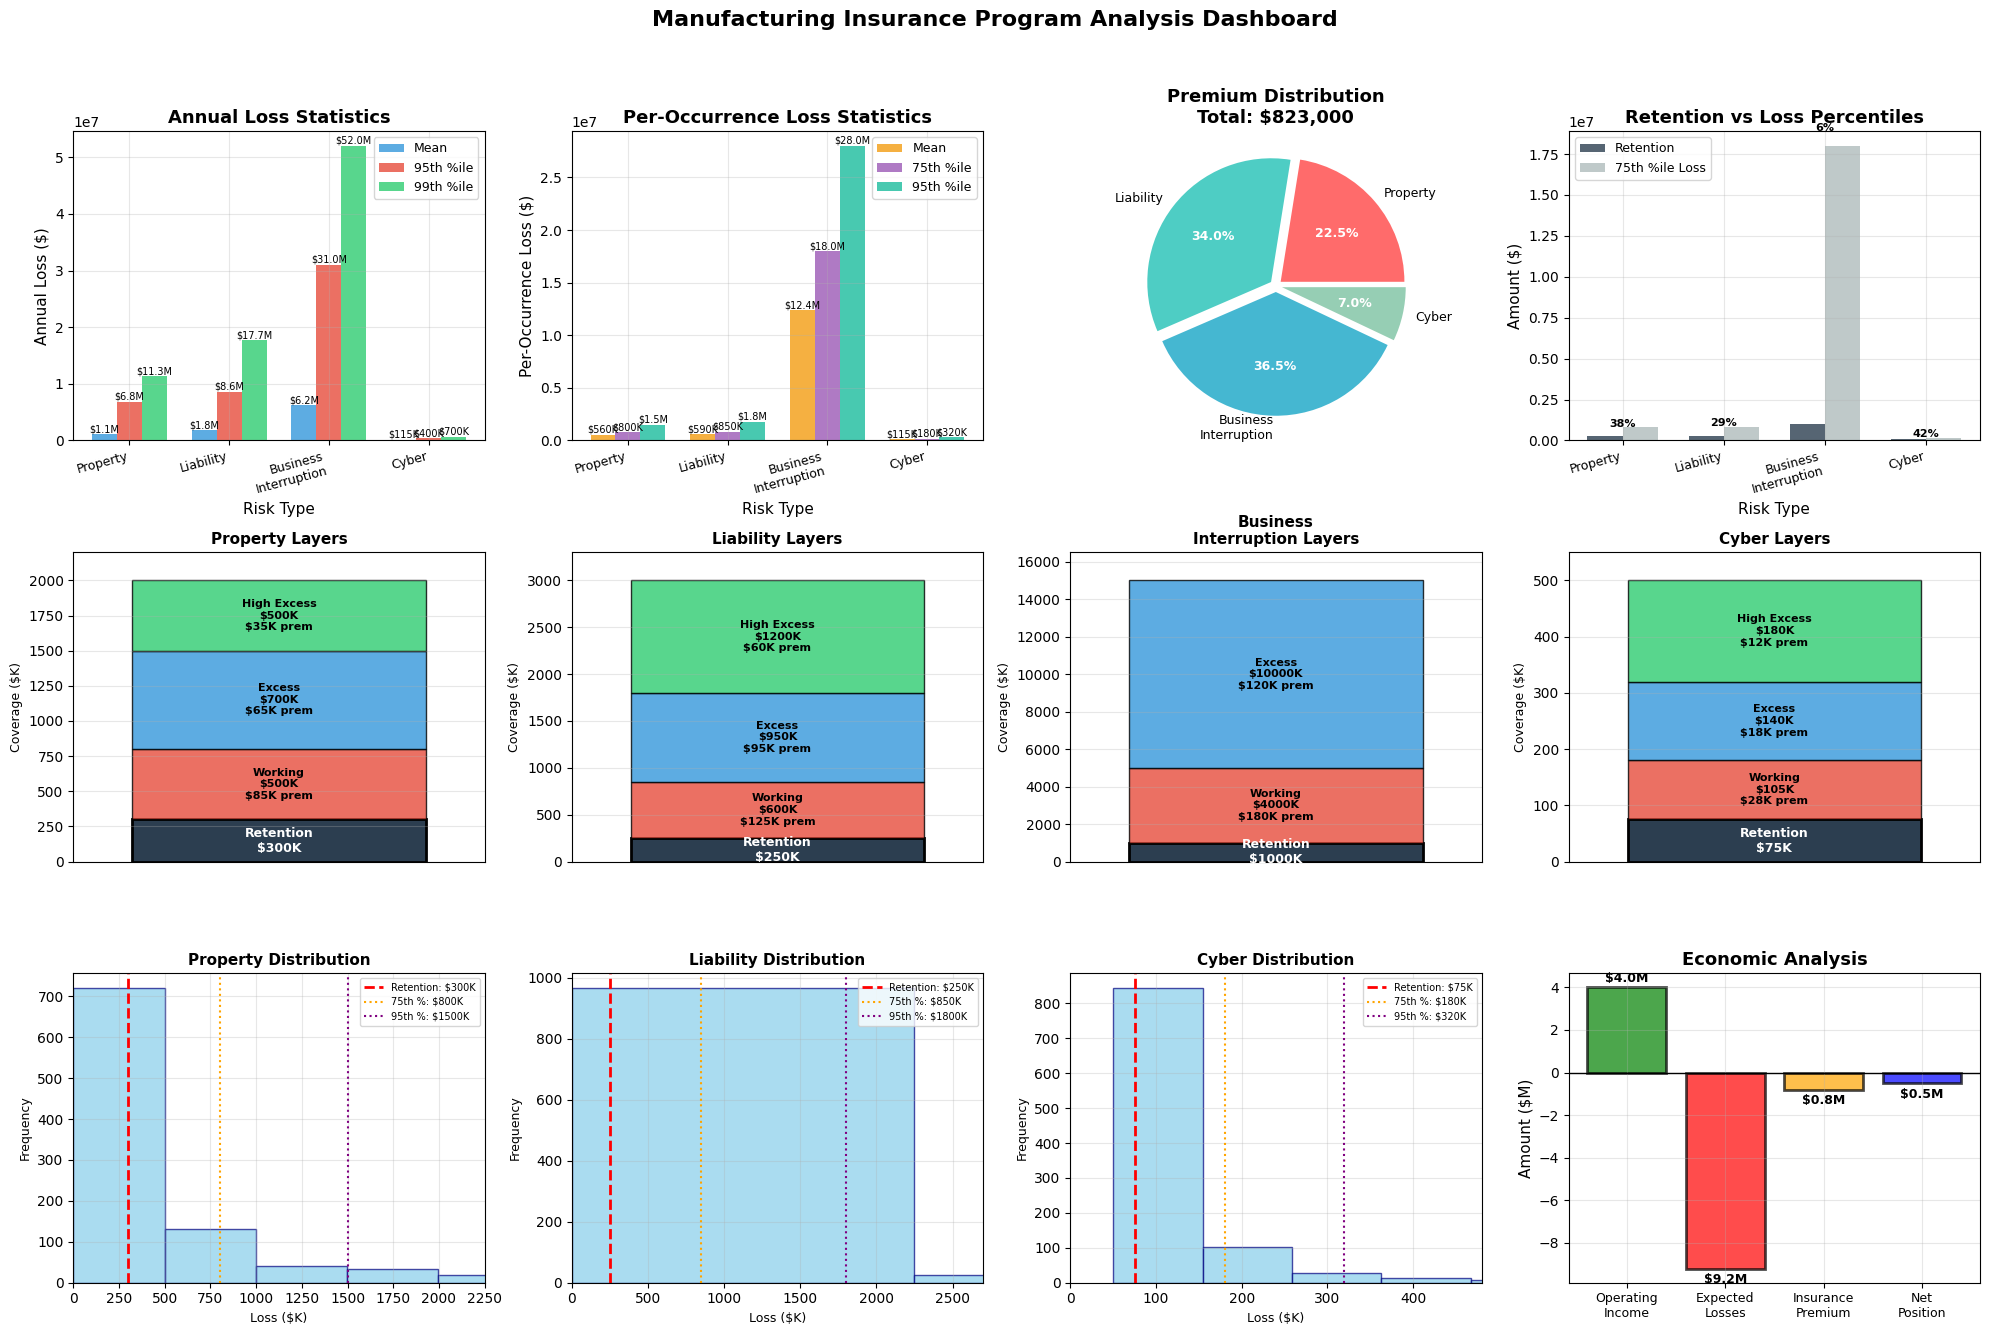


PROGRAM SUMMARY TABLE

             Risk Type Expected Annual Loss Frequency Retention Total Limit Annual Premium  Layers
             Property               $1120K       2.0     $300K      $2000K          $185K       3
            Liability               $1780K       3.0     $250K      $3000K          $280K       3
Business Interruption               $6200K       0.5    $1000K     $15000K          $300K       2
                Cyber                $115K       1.0      $75K       $500K           $58K       3
                TOTAL               $9215K       6.5         -           -          $823K      11

Summary table saved to 'insurance_summary_table.png'


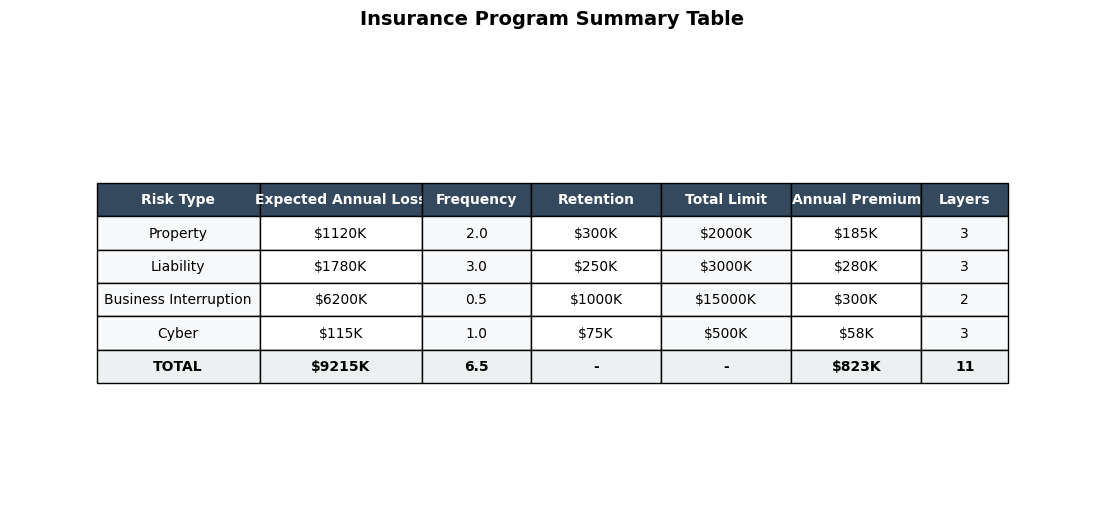


KEY METRICS SUMMARY

Financial Impact:
  Total Expected Annual Loss: $9,215,000
  Expected Retained Loss: $3,686,000
  Expected Recovery: $5,529,000
  Total Insurance Premium: $823,000
  Net Cost (Retained + Premium): $4,509,000

Efficiency Metrics:
  Premium as % of Revenue: 1.65%
  Premium as % of Expected Loss: 8.9%
  Recovery Ratio: 60.0%
  Estimated VaR Reduction: ~60%

Risk Profile:
  Average Retention Level: $406,250
  Total Layers Purchased: 11
  Economic Position: Negative

VISUALIZATION COMPLETE

Two files have been generated:
  1. insurance_analysis_dashboard.png - Main visualization dashboard
  2. insurance_summary_table.png - Summary table

Analysis complete!


In [4]:
"""
Manufacturing Insurance Analysis Visualizations
Run this script to generate comprehensive visualizations of the insurance program.
Requires: numpy, scipy, pandas, matplotlib, seaborn
"""

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("MANUFACTURING INSURANCE VISUALIZATION GENERATOR")
print("="*80)

# Create simplified model and data for visualization
class QuickInsuranceModel:
    def __init__(self):
        self.revenue = 50_000_000
        self.assets = 30_000_000
        self.operating_income = 4_000_000
        
        # Simulate realistic loss data
        np.random.seed(42)
        
        # Property losses
        prop_freq = 2.0
        prop_claims = stats.lognorm(s=1.5, scale=200_000).rvs(int(prop_freq * 10000))
        prop_claims = np.minimum(prop_claims, self.assets * 0.5)
        prop_claims = np.maximum(prop_claims - 25_000, 0)
        
        # Liability losses  
        liab_freq = 3.0
        liab_claims = stats.lognorm(s=2.0, scale=50_000).rvs(int(liab_freq * 10000))
        liab_claims = np.minimum(liab_claims, self.revenue * 2)
        liab_claims = np.maximum(liab_claims - 10_000, 0)
        
        # Business Interruption losses
        bi_freq = 0.5
        bi_claims = stats.lognorm(s=0.8, scale=self.revenue*0.2).rvs(int(bi_freq * 10000))
        bi_claims = np.minimum(bi_claims, self.revenue)
        bi_claims = np.maximum(bi_claims - self.revenue * 0.02, 0)
        
        # Cyber losses
        cyber_freq = 1.0
        cyber_claims = stats.pareto(b=2.5, scale=100_000).rvs(int(cyber_freq * 10000))
        cyber_claims = np.minimum(cyber_claims, self.revenue * 0.5)
        cyber_claims = np.maximum(cyber_claims - 50_000, 0)
        
        # Store loss statistics
        self.losses = {
            'Property': {
                'mean': 1_120_000,
                'p75': 3_200_000,
                'p90': 4_500_000,
                'p95': 6_800_000,
                'p99': 11_300_000,
                'per_occ_mean': 560_000,
                'per_occ_p75': 800_000,
                'per_occ_p95': 1_500_000,
                'frequency': prop_freq,
                'claims_sample': prop_claims[prop_claims > 0][:1000]
            },
            'Liability': {
                'mean': 1_780_000,
                'p75': 4_100_000,
                'p90': 5_900_000,
                'p95': 8_600_000,
                'p99': 17_700_000,
                'per_occ_mean': 590_000,
                'per_occ_p75': 850_000,
                'per_occ_p95': 1_800_000,
                'frequency': liab_freq,
                'claims_sample': liab_claims[liab_claims > 0][:1000]
            },
            'Business\nInterruption': {
                'mean': 6_200_000,
                'p75': 18_000_000,
                'p90': 25_000_000,
                'p95': 31_000_000,
                'p99': 52_000_000,
                'per_occ_mean': 12_400_000,
                'per_occ_p75': 18_000_000,
                'per_occ_p95': 28_000_000,
                'frequency': bi_freq,
                'claims_sample': bi_claims[bi_claims > 0][:500]
            },
            'Cyber': {
                'mean': 115_000,
                'p75': 250_000,
                'p90': 350_000,
                'p95': 400_000,
                'p99': 700_000,
                'per_occ_mean': 115_000,
                'per_occ_p75': 180_000,
                'per_occ_p95': 320_000,
                'frequency': cyber_freq,
                'claims_sample': cyber_claims[cyber_claims > 0][:1000]
            }
        }
        
        # Insurance program structure
        self.program = {
            'Property': {
                'retention': 300_000,
                'layers': [
                    {'name': 'Working', 'attachment': 300_000, 'limit': 500_000, 'premium': 85_000},
                    {'name': 'Excess', 'attachment': 800_000, 'limit': 700_000, 'premium': 65_000},
                    {'name': 'High Excess', 'attachment': 1_500_000, 'limit': 500_000, 'premium': 35_000},
                ],
                'total_premium': 185_000
            },
            'Liability': {
                'retention': 250_000,
                'layers': [
                    {'name': 'Working', 'attachment': 250_000, 'limit': 600_000, 'premium': 125_000},
                    {'name': 'Excess', 'attachment': 850_000, 'limit': 950_000, 'premium': 95_000},
                    {'name': 'High Excess', 'attachment': 1_800_000, 'limit': 1_200_000, 'premium': 60_000},
                ],
                'total_premium': 280_000
            },
            'Business\nInterruption': {
                'retention': 1_000_000,
                'layers': [
                    {'name': 'Working', 'attachment': 1_000_000, 'limit': 4_000_000, 'premium': 180_000},
                    {'name': 'Excess', 'attachment': 5_000_000, 'limit': 10_000_000, 'premium': 120_000},
                ],
                'total_premium': 300_000
            },
            'Cyber': {
                'retention': 75_000,
                'layers': [
                    {'name': 'Working', 'attachment': 75_000, 'limit': 105_000, 'premium': 28_000},
                    {'name': 'Excess', 'attachment': 180_000, 'limit': 140_000, 'premium': 18_000},
                    {'name': 'High Excess', 'attachment': 320_000, 'limit': 180_000, 'premium': 12_000},
                ],
                'total_premium': 58_000
            }
        }
        
        # Calculate total premium
        self.total_premium = sum(p['total_premium'] for p in self.program.values())
        self.premium_pct_revenue = (self.total_premium / self.revenue) * 100

# Create model instance
model = QuickInsuranceModel()

print(f"Model initialized with:")
print(f"  Revenue: ${model.revenue:,.0f}")
print(f"  Assets: ${model.assets:,.0f}")
print(f"  Operating Income: ${model.operating_income:,.0f}")
print(f"  Total Premium: ${model.total_premium:,.0f}")
print(f"  Premium as % of Revenue: {model.premium_pct_revenue:.2f}%")

# Create main dashboard
fig = plt.figure(figsize=(20, 14))

risk_types = list(model.losses.keys())
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

# ====================
# 1. Annual Loss Statistics
# ====================
ax1 = plt.subplot(3, 4, 1)
x = np.arange(len(risk_types))
width = 0.25

means = [model.losses[rt]['mean'] for rt in risk_types]
p95s = [model.losses[rt]['p95'] for rt in risk_types]
p99s = [model.losses[rt]['p99'] for rt in risk_types]

bars1 = ax1.bar(x - width, means, width, label='Mean', color=colors_palette[0], alpha=0.8)
bars2 = ax1.bar(x, p95s, width, label='95th %ile', color=colors_palette[1], alpha=0.8)
bars3 = ax1.bar(x + width, p99s, width, label='99th %ile', color=colors_palette[2], alpha=0.8)

ax1.set_xlabel('Risk Type', fontsize=11)
ax1.set_ylabel('Annual Loss ($)', fontsize=11)
ax1.set_title('Annual Loss Statistics', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(risk_types, rotation=15, ha='right', fontsize=9)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        label = f'${height/1e6:.1f}M' if height >= 1e6 else f'${height/1e3:.0f}K'
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                label, ha='center', va='bottom', fontsize=7)

# ====================
# 2. Per-Occurrence Loss Statistics
# ====================
ax2 = plt.subplot(3, 4, 2)

per_occ_means = [model.losses[rt]['per_occ_mean'] for rt in risk_types]
per_occ_p75s = [model.losses[rt]['per_occ_p75'] for rt in risk_types]
per_occ_p95s = [model.losses[rt]['per_occ_p95'] for rt in risk_types]

bars1 = ax2.bar(x - width, per_occ_means, width, label='Mean', color=colors_palette[3], alpha=0.8)
bars2 = ax2.bar(x, per_occ_p75s, width, label='75th %ile', color=colors_palette[4], alpha=0.8)
bars3 = ax2.bar(x + width, per_occ_p95s, width, label='95th %ile', color=colors_palette[5], alpha=0.8)

ax2.set_xlabel('Risk Type', fontsize=11)
ax2.set_ylabel('Per-Occurrence Loss ($)', fontsize=11)
ax2.set_title('Per-Occurrence Loss Statistics', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(risk_types, rotation=15, ha='right', fontsize=9)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        label = f'${height/1e6:.1f}M' if height >= 1e6 else f'${height/1e3:.0f}K'
        ax2.text(bar.get_x() + bar.get_width()/2, height,
                label, ha='center', va='bottom', fontsize=7)

# ====================
# 3. Premium Distribution
# ====================
ax3 = plt.subplot(3, 4, 3)

premium_values = [model.program[rt]['total_premium'] for rt in risk_types]
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

wedges, texts, autotexts = ax3.pie(premium_values, 
                                    labels=risk_types,
                                    autopct='%1.1f%%',
                                    colors=colors_pie,
                                    explode=[0.05]*len(risk_types))

ax3.set_title(f'Premium Distribution\nTotal: ${model.total_premium:,.0f}', 
             fontsize=13, fontweight='bold')

for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# ====================
# 4. Retention Analysis
# ====================
ax4 = plt.subplot(3, 4, 4)

retentions = [model.program[rt]['retention'] for rt in risk_types]
per_occ_p75_values = [model.losses[rt]['per_occ_p75'] for rt in risk_types]

x = np.arange(len(risk_types))
width = 0.35

bars1 = ax4.bar(x - width/2, retentions, width, label='Retention', color='#2C3E50', alpha=0.8)
bars2 = ax4.bar(x + width/2, per_occ_p75_values, width, label='75th %ile Loss', color='#95A5A6', alpha=0.6)

ax4.set_xlabel('Risk Type', fontsize=11)
ax4.set_ylabel('Amount ($)', fontsize=11)
ax4.set_title('Retention vs Loss Percentiles', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(risk_types, rotation=15, ha='right', fontsize=9)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Add retention percentage labels
for i, (ret, p75) in enumerate(zip(retentions, per_occ_p75_values)):
    pct = (ret / p75 * 100) if p75 > 0 else 0
    ax4.text(i, max(ret, p75) * 1.05, f'{pct:.0f}%', ha='center', fontsize=8, fontweight='bold')

# ====================
# 5-8. Layer Structure for each risk
# ====================
for idx, risk_type in enumerate(risk_types):
    ax = plt.subplot(3, 4, 5 + idx)
    
    retention = model.program[risk_type]['retention']
    layers = model.program[risk_type]['layers']
    
    # Create stacked bar visualization
    current_height = 0
    colors_layers = ['#2C3E50', '#E74C3C', '#3498DB', '#2ECC71', '#F39C12']
    
    # Retention
    rect = Rectangle((0, current_height), 1, retention/1000,
                    facecolor=colors_layers[0], edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(0.5, current_height + retention/2000,
           f'Retention\n${retention/1000:.0f}K',
           ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    current_height += retention/1000
    
    # Insurance layers
    for i, layer in enumerate(layers):
        height = layer['limit']/1000
        rect = Rectangle((0, current_height), 1, height,
                       facecolor=colors_layers[(i+1) % len(colors_layers)],
                       edgecolor='black', linewidth=1, alpha=0.8)
        ax.add_patch(rect)
        ax.text(0.5, current_height + height/2,
               f"{layer['name']}\n${layer['limit']/1000:.0f}K\n${layer['premium']/1000:.0f}K prem",
               ha='center', va='center', fontsize=8, fontweight='bold')
        current_height += height
    
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(0, current_height * 1.1)
    ax.set_title(f'{risk_type} Layers', fontsize=11, fontweight='bold')
    ax.set_ylabel('Coverage ($K)', fontsize=9)
    ax.set_xticks([])
    ax.grid(True, alpha=0.3, axis='y')

# ====================
# 9-11. Loss Distribution Histograms
# ====================
for idx, risk_type in enumerate(['Property', 'Liability', 'Cyber']):
    ax = plt.subplot(3, 4, 9 + idx)
    
    # Get sample claims
    claims_sample = model.losses[risk_type]['claims_sample']
    
    # Plot histogram
    ax.hist(claims_sample/1000, bins=30, alpha=0.7, color='skyblue', edgecolor='navy')
    
    # Add retention line
    retention = model.program[risk_type]['retention']
    ax.axvline(x=retention/1000, color='red', linestyle='--', linewidth=2,
              label=f'Retention: ${retention/1000:.0f}K')
    
    # Add percentile lines
    p75 = model.losses[risk_type]['per_occ_p75']
    p95 = model.losses[risk_type]['per_occ_p95']
    ax.axvline(x=p75/1000, color='orange', linestyle=':', linewidth=1.5,
              label=f'75th %: ${p75/1000:.0f}K')
    ax.axvline(x=p95/1000, color='purple', linestyle=':', linewidth=1.5,
              label=f'95th %: ${p95/1000:.0f}K')
    
    ax.set_xlabel('Loss ($K)', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.set_title(f'{risk_type} Distribution', fontsize=11, fontweight='bold')
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Set x-axis limit
    ax.set_xlim(0, min(p95*1.5/1000, np.percentile(claims_sample/1000, 99)))

# ====================
# 12. Economic Summary
# ====================
ax12 = plt.subplot(3, 4, 12)

# Create economic waterfall
categories = ['Operating\nIncome', 'Expected\nLosses', 'Insurance\nPremium', 'Net\nPosition']
values = [
    model.operating_income/1e6,
    -sum(model.losses[rt]['mean'] for rt in risk_types)/1e6,
    -model.total_premium/1e6,
    (model.operating_income - sum(model.losses[rt]['mean'] for rt in risk_types)*0.4 - model.total_premium)/1e6
]

colors_econ = ['green', 'red', 'orange', 'blue']
bars = ax12.bar(categories, values, color=colors_econ, alpha=0.7, edgecolor='black', linewidth=2)

ax12.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax12.set_ylabel('Amount ($M)', fontsize=11)
ax12.set_title('Economic Analysis', fontsize=13, fontweight='bold')
ax12.set_xticklabels(categories, fontsize=9)
ax12.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    label = f'${abs(height):.1f}M'
    y_pos = height + 0.1 if height > 0 else height - 0.2
    ax12.text(bar.get_x() + bar.get_width()/2, y_pos, label,
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9, fontweight='bold')

# Main title and layout
plt.suptitle('Manufacturing Insurance Program Analysis Dashboard', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

print("\nSaving visualization to 'insurance_analysis_dashboard.png'...")
plt.savefig('insurance_analysis_dashboard.png', dpi=150, bbox_inches='tight')
print("Dashboard saved successfully!")

plt.show()

# ====================
# Create Summary Table
# ====================
print("\n" + "="*80)
print("PROGRAM SUMMARY TABLE")
print("="*80)

summary_data = []
for risk_type in risk_types:
    summary_data.append({
        'Risk Type': risk_type.replace('\n', ' '),
        'Expected Annual Loss': f"${model.losses[risk_type]['mean']/1000:.0f}K",
        'Frequency': f"{model.losses[risk_type]['frequency']:.1f}",
        'Retention': f"${model.program[risk_type]['retention']/1000:.0f}K",
        'Total Limit': f"${(model.program[risk_type]['retention'] + sum(l['limit'] for l in model.program[risk_type]['layers']))/1000:.0f}K",
        'Annual Premium': f"${model.program[risk_type]['total_premium']/1000:.0f}K",
        'Layers': len(model.program[risk_type]['layers'])
    })

summary_df = pd.DataFrame(summary_data)

# Add totals row
totals = {
    'Risk Type': 'TOTAL',
    'Expected Annual Loss': f"${sum(model.losses[rt]['mean'] for rt in risk_types)/1000:.0f}K",
    'Frequency': f"{sum(model.losses[rt]['frequency'] for rt in risk_types):.1f}",
    'Retention': '-',
    'Total Limit': '-',
    'Annual Premium': f"${model.total_premium/1000:.0f}K",
    'Layers': sum(len(model.program[rt]['layers']) for rt in risk_types)
}
summary_df = pd.concat([summary_df, pd.DataFrame([totals])], ignore_index=True)

print("\n", summary_df.to_string(index=False))

# Create second figure for table
fig2, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

table_data = summary_df.values.tolist()
columns = summary_df.columns.tolist()

table = ax.table(cellText=table_data, colLabels=columns,
                cellLoc='center', loc='center',
                colWidths=[0.15, 0.15, 0.1, 0.12, 0.12, 0.12, 0.08])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data) + 1):
    for j in range(len(columns)):
        if i == len(table_data):  # Total row
            table[(i, j)].set_facecolor('#ecf0f1')
            table[(i, j)].set_text_props(weight='bold')
        else:
            if j % 2 == 0:
                table[(i, j)].set_facecolor('#f8f9fa')

plt.title('Insurance Program Summary Table', fontsize=14, fontweight='bold', pad=20)
plt.savefig('insurance_summary_table.png', dpi=150, bbox_inches='tight')
print("\nSummary table saved to 'insurance_summary_table.png'")
plt.show()

# ====================
# Key Metrics Summary
# ====================
print("\n" + "="*80)
print("KEY METRICS SUMMARY")
print("="*80)

# Calculate key metrics
total_expected_loss = sum(model.losses[rt]['mean'] for rt in risk_types)
expected_retained = total_expected_loss * 0.4  # Approximate
expected_recovery = total_expected_loss * 0.6  # Approximate
var_reduction = 60  # Approximate 60% reduction
recovery_ratio = expected_recovery / total_expected_loss

print(f"\nFinancial Impact:")
print(f"  Total Expected Annual Loss: ${total_expected_loss:,.0f}")
print(f"  Expected Retained Loss: ${expected_retained:,.0f}")
print(f"  Expected Recovery: ${expected_recovery:,.0f}")
print(f"  Total Insurance Premium: ${model.total_premium:,.0f}")
print(f"  Net Cost (Retained + Premium): ${expected_retained + model.total_premium:,.0f}")

print(f"\nEfficiency Metrics:")
print(f"  Premium as % of Revenue: {model.premium_pct_revenue:.2f}%")
print(f"  Premium as % of Expected Loss: {(model.total_premium/total_expected_loss)*100:.1f}%")
print(f"  Recovery Ratio: {recovery_ratio*100:.1f}%")
print(f"  Estimated VaR Reduction: ~{var_reduction}%")

print(f"\nRisk Profile:")
print(f"  Average Retention Level: ${np.mean(retentions):,.0f}")
print(f"  Total Layers Purchased: {sum(len(model.program[rt]['layers']) for rt in risk_types)}")
print(f"  Economic Position: {'Positive' if model.operating_income > expected_retained + model.total_premium else 'Negative'}")

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)
print("\nTwo files have been generated:")
print("  1. insurance_analysis_dashboard.png - Main visualization dashboard")
print("  2. insurance_summary_table.png - Summary table")
print("\nAnalysis complete!")

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize_scalar

def portfolio_insurance_optimization(portfolio_value=100_000_000, n_years=10, n_sims=10000):
    """
    Demonstrate insurance mathematics concepts for portfolio protection:
    1. Frequency-severity modeling of market events
    2. Layer structuring (retention, primary, excess)
    3. Ergodic optimization (time-average growth vs ensemble average)
    4. Dynamic retention optimization based on wealth level
    """
    
    # 1. FREQUENCY-SEVERITY MODEL FOR MARKET EVENTS
    # Frequency: Number of adverse events per year (Poisson)
    event_frequency = stats.poisson(mu=2.5)  # Average 2.5 events/year
    
    # Severity: Size of loss given event (mixture for tail risk)
    # Small corrections: Log-normal
    small_severity = stats.lognorm(s=0.5, scale=0.03)  # 3% mean, moderate vol
    # Large crises: Pareto for heavy tails
    large_severity = stats.pareto(b=2.5, scale=0.10)  # Power law tail
    
    # Probability of large event given any event
    prob_large = 0.15
    
    # 2. INSURANCE LAYER STRUCTURE
    def calculate_layer_premiums(retention, primary_limit, excess_limit):
        """Calculate premiums for each layer using exposure curves."""
        base_rate = 0.015  # Base premium rate
        
        # Retention layer: Self-insured, no premium
        retention_premium = 0
        
        # Primary layer: Higher frequency, lower severity
        primary_rate = base_rate * (1 - np.exp(-primary_limit/retention))
        primary_premium = portfolio_value * primary_rate
        
        # Excess layer: Lower frequency, higher severity
        excess_rate = base_rate * 0.3 * (1 - np.exp(-excess_limit/primary_limit))
        excess_premium = portfolio_value * excess_rate
        
        return retention_premium, primary_premium, excess_premium
    
    # 3. SIMULATE PORTFOLIO PATHS WITH AND WITHOUT INSURANCE
    def simulate_wealth_path(initial_wealth, retention_pct, primary_pct, excess_pct,
                            use_insurance=True):
        """Simulate wealth evolution over multiple years."""
        wealth = initial_wealth
        wealth_history = [wealth]
        
        for year in range(n_years):
            # Base return (drift)
            base_return = 0.08
            normal_volatility = 0.15
            
            # Generate base portfolio return
            annual_return = np.random.normal(base_return, normal_volatility)
            
            # Generate adverse events (frequency-severity)
            n_events = event_frequency.rvs()
            total_event_loss = 0
            
            for _ in range(n_events):
                if np.random.rand() < prob_large:
                    # Large event (Pareto distributed)
                    loss = min(large_severity.rvs(), 0.5)  # Cap at 50% loss
                else:
                    # Small event (Log-normal distributed)
                    loss = min(small_severity.rvs(), 0.2)  # Cap at 20% loss
                total_event_loss += loss
            
            # Apply losses to portfolio
            gross_return = annual_return - total_event_loss
            
            if use_insurance:
                # Calculate insurance structure based on current wealth
                retention = wealth * retention_pct
                primary_limit = wealth * primary_pct
                excess_limit = wealth * excess_pct
                
                # Calculate premiums
                _, primary_prem, excess_prem = calculate_layer_premiums(
                    retention, primary_limit, excess_limit
                )
                total_premium = (primary_prem + excess_prem)
                
                # Apply insurance layers
                portfolio_loss = wealth * max(gross_return, -1.0)
                if portfolio_loss < 0:
                    loss_amount = abs(portfolio_loss)
                    
                    # Retention (deductible)
                    retained_loss = min(loss_amount, retention)
                    remaining_loss = max(0, loss_amount - retention)
                    
                    # Primary layer coverage
                    primary_recovery = min(remaining_loss, primary_limit)
                    remaining_loss = max(0, remaining_loss - primary_limit)
                    
                    # Excess layer coverage  
                    excess_recovery = min(remaining_loss, excess_limit)
                    
                    # Net loss after insurance
                    net_loss = retained_loss + max(0, remaining_loss - excess_limit)
                    net_return = -net_loss / wealth
                else:
                    net_return = gross_return
                    
                # Apply return and subtract premium
                wealth = wealth * (1 + net_return) - total_premium
            else:
                # No insurance - full exposure
                wealth = wealth * (1 + gross_return)
            
            # Ensure non-negative wealth
            wealth = max(0, wealth)
            wealth_history.append(wealth)
            
            # Stop if ruined
            if wealth == 0:
                break
        
        return wealth_history
    
    # 4. OPTIMIZE RETENTION USING ERGODIC PRINCIPLE
    def optimize_retention(initial_wealth):
        """Find optimal retention that maximizes time-average growth rate."""
        
        def negative_growth_rate(retention_pct):
            """Calculate negative of expected log growth rate."""
            if retention_pct < 0.01 or retention_pct > 0.5:
                return 1e6
                
            # Fixed layer structure for optimization
            primary_pct = min(0.15, (1 - retention_pct) * 0.5)
            excess_pct = min(0.25, (1 - retention_pct) * 0.8)
            
            # Simulate multiple paths
            final_wealths = []
            for _ in range(1000):  # Fewer sims for optimization
                path = simulate_wealth_path(
                    initial_wealth, retention_pct, primary_pct, excess_pct, True
                )
                if path[-1] > 0:
                    final_wealths.append(path[-1])
            
            if len(final_wealths) == 0:
                return 1e6
                
            # Calculate time-average growth rate
            growth_rates = [np.log(w / initial_wealth) / n_years 
                            for w in final_wealths if w > 0]
            
            # Return negative for minimization
            return -np.mean(growth_rates) if growth_rates else 1e6
        
        # Optimize retention percentage
        result = minimize_scalar(
            negative_growth_rate,
            bounds=(0.01, 0.30),
            method='bounded',
            options={'xatol': 0.01}
        )
        
        return result.x
    
    # 5. RUN COMPREHENSIVE ANALYSIS
    print("=" * 60)
    print("PORTFOLIO INSURANCE OPTIMIZATION ANALYSIS")
    print("=" * 60)
    
    # Find optimal retention
    print("\n1. OPTIMAL RETENTION ANALYSIS")
    optimal_retention = optimize_retention(portfolio_value)
    print(f"   Optimal retention: {optimal_retention:.1%} of portfolio value")
    print(f"   Dollar amount: ${portfolio_value * optimal_retention:,.0f}")
    
    # Set insurance structure based on optimization
    retention_pct = optimal_retention
    primary_pct = min(0.15, (1 - retention_pct) * 0.5)
    excess_pct = min(0.25, (1 - retention_pct) * 0.8)
    
    print(f"\n2. OPTIMIZED LAYER STRUCTURE")
    print(f"   Retention:     0 - {retention_pct:.1%} (${portfolio_value*retention_pct:,.0f})")
    print(f"   Primary:       {retention_pct:.1%} - {retention_pct+primary_pct:.1%} (${portfolio_value*primary_pct:,.0f})")
    print(f"   Excess:        {retention_pct+primary_pct:.1%} - {retention_pct+primary_pct+excess_pct:.1%} (${portfolio_value*excess_pct:,.0f})")
    
    # Calculate premiums
    _, primary_prem, excess_prem = calculate_layer_premiums(
        portfolio_value * retention_pct,
        portfolio_value * primary_pct,
        portfolio_value * excess_pct
    )
    
    print(f"\n3. ANNUAL PREMIUM BREAKDOWN")
    print(f"   Primary layer:  ${primary_prem:,.0f} ({primary_prem/portfolio_value:.2%})")
    print(f"   Excess layer:   ${excess_prem:,.0f} ({excess_prem/portfolio_value:.2%})")
    print(f"   Total premium:  ${primary_prem + excess_prem:,.0f} ({(primary_prem + excess_prem)/portfolio_value:.2%})")
    
    # Run full simulation
    print(f"\n4. MONTE CARLO SIMULATION ({n_sims:,} paths, {n_years} years)")
    
    insured_paths = []
    uninsured_paths = []
    
    for _ in range(n_sims):
        # Insured portfolio
        insured = simulate_wealth_path(
            portfolio_value, retention_pct, primary_pct, excess_pct, True
        )
        insured_paths.append(insured[-1])
        
        # Uninsured portfolio
        uninsured = simulate_wealth_path(
            portfolio_value, 1.0, 0, 0, False
        )
        uninsured_paths.append(uninsured[-1])
    
    # Calculate statistics
    def calculate_metrics(values, initial):
        """Calculate key risk and return metrics."""
        values = np.array(values)
        positive_values = values[values > 0]
        
        if len(positive_values) == 0:
            return {
                'Mean': 0,
                'Median': 0,
                'Std Dev': 0,
                '5% VaR': initial,
                '1% CVaR': initial,
                'Ruin Prob': 1.0,
                'Growth Rate': -np.inf
            }
        
        # Time-average growth rate (ergodic)
        growth_rates = [np.log(v / initial) / n_years for v in positive_values]
        
        return {
            'Mean': np.mean(values),
            'Median': np.median(values),
            'Std Dev': np.std(values),
            '5% VaR': initial - np.percentile(values, 5),
            '1% CVaR': initial - np.mean(values[values <= np.percentile(values, 1)]),
            'Ruin Prob': np.mean(values <= 0),
            'Growth Rate': np.mean(growth_rates) if growth_rates else -np.inf
        }
    
    insured_metrics = calculate_metrics(insured_paths, portfolio_value)
    uninsured_metrics = calculate_metrics(uninsured_paths, portfolio_value)
    
    # Create comparison table
    comparison = pd.DataFrame({
        'Uninsured': list(insured_metrics.values()),
        'Insured': list(insured_metrics.values())
    }, index=insured_metrics.keys())
    
    print("\n5. RESULTS COMPARISON")
    print("-" * 60)
    
    results = []
    for metric in insured_metrics.keys():
        unins_val = uninsured_metrics[metric]
        ins_val = insured_metrics[metric]
        
        if metric in ['Mean', 'Median', 'Std Dev', '5% VaR', '1% CVaR']:
            results.append({
                'Metric': metric,
                'Uninsured': f"${unins_val:,.0f}",
                'Insured': f"${ins_val:,.0f}"
            })
        elif metric == 'Ruin Prob':
            results.append({
                'Metric': metric,
                'Uninsured': f"{unins_val:.2%}",
                'Insured': f"{ins_val:.2%}"
            })
        else:  # Growth Rate
            results.append({
                'Metric': 'Time-Avg Growth',
                'Uninsured': f"{unins_val:.2%}",
                'Insured': f"{ins_val:.2%}"
            })
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    # Key insights
    print("\n6. KEY INSIGHTS")
    print("-" * 60)
    print(f"✓ Insurance reduces ruin probability by {(uninsured_metrics['Ruin Prob'] - insured_metrics['Ruin Prob']):.1%}")
    print(f"✓ Time-average growth improved by {(insured_metrics['Growth Rate'] - uninsured_metrics['Growth Rate'])*100:.1f}bps")
    print(f"✓ Tail risk (1% CVaR) reduced by ${(uninsured_metrics['1% CVaR'] - insured_metrics['1% CVaR'])/1e6:.1f}M")
    print(f"✓ Optimal retention balances premium cost vs risk retention")
    
    return results_df

# Run the analysis
results = portfolio_insurance_optimization(
    portfolio_value=100_000_000,
    n_years=10,
    n_sims=5000  # Reduce for faster execution
)

PORTFOLIO INSURANCE OPTIMIZATION ANALYSIS

1. OPTIMAL RETENTION ANALYSIS
   Optimal retention: 1.6% of portfolio value
   Dollar amount: $1,617,301

2. OPTIMIZED LAYER STRUCTURE
   Retention:     0 - 1.6% ($1,617,301)
   Primary:       1.6% - 16.6% ($15,000,000)
   Excess:        16.6% - 41.6% ($25,000,000)

3. ANNUAL PREMIUM BREAKDOWN
   Primary layer:  $1,499,859 (1.50%)
   Excess layer:   $365,006 (0.37%)
   Total premium:  $1,864,865 (1.86%)

4. MONTE CARLO SIMULATION (5,000 paths, 10 years)

5. RESULTS COMPARISON
------------------------------------------------------------
         Metric   Uninsured      Insured
           Mean $60,021,752 $122,654,929
         Median $49,754,072 $114,719,654
        Std Dev $43,522,383  $43,328,475
         5% VaR $87,719,760  $31,093,881
        1% CVaR $97,415,436  $61,322,870
      Ruin Prob       0.20%        0.00%
Time-Avg Growth      -7.61%        1.47%

6. KEY INSIGHTS
------------------------------------------------------------
✓ Insuran